In [1]:
# Add description here
#
# *Note:* You can open this file as a notebook (JupyterLab: right-click on it in the side bar -> Open With -> Notebook)

In [2]:
# Uncomment the next two lines to enable auto reloading for imported modules
# %load_ext autoreload
# %autoreload 2
# For more info, see:
# https://docs.ploomber.io/en/latest/user-guide/faq_index.html#auto-reloading-code-in-jupyter

from datetime import timedelta

In [3]:
# If this task has dependencies, declare them in the YAML spec and leave this
# as None
from pathlib import Path

import numpy as np
import statsmodels.api as sm
from sktime.forecasting.ets import AutoETS
from sktime.forecasting.exp_smoothing import ExponentialSmoothing
from sktime.forecasting.model_selection import ExpandingWindowSplitter
from sktime.forecasting.trend import STLForecaster
from sktime.transformations.series.detrend import STLTransformer

from hydro_timeseries.plotting import get_windows, tsplot, trend_eval_plot
from hydro_timeseries.util import load_timeseries_csv, add_mean_vars, generate_cyclical_features, cv_evaluate, smape, \
    rmse, mae
from hydro_timeseries.variables import Variables

upstream = None

# This is a placeholder, leave it as None
product = None
arima_init_steps = None
n_lags = None
import warnings
warnings.filterwarnings("ignore")

In [4]:
# Parameters
random_seed = 1
valid_from = "2021-11-01"
n_lags = 7
arima_init_steps = 7
plots_path = "/home/m/repo/hydro-power-prediction/plots"
upstream = {"run-tests": {"nb": "/home/m/repo/hydro-power-prediction/reports/run_tests.ipynb", "data": "/home/m/repo/hydro-power-prediction/products/data/data_raw_tested.csv"}}
product = {"nb": "/home/m/repo/hydro-power-prediction/reports/feature_manual.ipynb", "data": "/home/m/repo/hydro-power-prediction/products/data/feature_manual.csv"}


In [5]:
data = load_timeseries_csv(upstream['run-tests']['data'])
data = add_mean_vars(data)

plots_path = Path(plots_path)

In [6]:
'''
Cyclical datetime features
'''
data = (
        data
        # .assign(hour = data.index.hour)
        # .assign(day_of_month = data.index.day)
        .assign(month = data.index.month)
        # .assign(day_of_week = data.index.dayofweek)
        .assign(day_of_year = data.index.day_of_year)
        .assign(week_of_year = data.index.week)
        )

In [7]:
data = generate_cyclical_features(data, 'month', 12, 1)
data = generate_cyclical_features(data, 'week_of_year', 53, 1)
data = generate_cyclical_features(data, 'day_of_year', 366, 1)

In [8]:
'''
Get daily means 
'''
data_daily = data.resample('D').mean()
value_daily = data.Value.resample('D').mean()

In [9]:
def generate_lagged_vars(df, n_lags, colname='Value', start_from=2):
    # df_n = df.copy()
    new_vars = []
    for n in range(start_from, n_lags + 1):
        new_var_name = f"daily_mean_{colname}_lag{n}"
        df[new_var_name] = df[colname].shift(n)
        new_vars.append(new_var_name)
    return df, new_vars

def generate_ewms(df, colname='Value', span_list=[3, 7, 14, 30], shift=2, var_suffix='daily'):
    # df_n = df.copy()
    new_vars = []
    for span in span_list:
        new_var_name = f"{colname}_{var_suffix}_ewm{span}"
        df[new_var_name] = df[colname].ewm(span=span).mean().shift(shift)
        new_vars.append(new_var_name)
    return df, new_vars

In [10]:
'''
Lagged Value means
lag has to be at least 2, because only the prev day is known when day ahead is being predicted
meteo can lag by 1. 
'''
data_daily, value_lag_vars = generate_lagged_vars(data_daily, colname='Value', n_lags=n_lags, start_from=2)
data_daily, precip_mean_vars = generate_lagged_vars(data_daily, colname='precip_mean', n_lags=n_lags, start_from=1)
data_daily, soil_moisture_mean_vars = generate_lagged_vars(data_daily, colname='soil_moisture_mean', n_lags=n_lags, start_from=1)
data_daily, snow_mean_vars = generate_lagged_vars(data_daily, colname='snow_mean', n_lags=n_lags, start_from=1)

lagged_selector = []
for var in Variables.meteo_i:
    data_daily, meteo_lagged_vars = generate_lagged_vars(data_daily, colname=var, n_lags=n_lags, start_from=1)
    lagged_selector = lagged_selector + meteo_lagged_vars

print("First two should be NaN, last two should be fine")
print(data_daily[['Value', 'daily_mean_Value_lag2']].head())
print(data_daily[['Value', 'daily_mean_Value_lag2']].tail())

First two should be NaN, last two should be fine
                  Value  daily_mean_Value_lag2
Date_Time                                     
2020-12-01  1161.843750                    NaN
2020-12-02  1198.062500                    NaN
2020-12-03  1238.145833            1161.843750
2020-12-04  1157.833333            1198.062500
2020-12-05  1310.260417            1238.145833
                  Value  daily_mean_Value_lag2
Date_Time                                     
2021-12-30   682.031250             808.281250
2021-12-31   943.135417             907.395833
2022-01-01  1367.218750             682.031250
2022-01-02          NaN             943.135417
2022-01-03          NaN            1367.218750


In [11]:
selector = lagged_selector + value_lag_vars + precip_mean_vars + soil_moisture_mean_vars + snow_mean_vars
data = data.join(data_daily[selector], how='left')
# data_joined.loc[:, value_lag_vars] = data[value_lag_vars].ffill()
data.loc[:, selector] = data[selector].ffill()

In [12]:
print("Value lag2, Value and daily_mean_Value_lag2 should be equal")
print(data_daily.loc['2022-01-01'].Value)
print(data.loc['2022-01-03'][['Value', 'daily_mean_Value_lag2']].head())

Value lag2, Value and daily_mean_Value_lag2 should be equal
1367.21875
                     Value  daily_mean_Value_lag2
Date_Time                                        
2022-01-03 00:00:00    NaN             1367.21875
2022-01-03 00:15:00    NaN             1367.21875
2022-01-03 00:30:00    NaN             1367.21875
2022-01-03 00:45:00    NaN             1367.21875
2022-01-03 01:00:00    NaN             1367.21875


In [13]:
print("precip_mean lag1, precip_mean and daily_mean_precip_mean_lag1 should be equal")
print(data_daily.loc['2022-01-02'].precip_mean)
print(data.loc['2022-01-03'][['precip_mean', 'daily_mean_precip_mean_lag1']].head())

precip_mean lag1, precip_mean and daily_mean_precip_mean_lag1 should be equal
0.004166666666666667
                     precip_mean  daily_mean_precip_mean_lag1
Date_Time                                                    
2022-01-03 00:00:00          0.0                     0.004167
2022-01-03 00:15:00          0.0                     0.004167
2022-01-03 00:30:00          0.0                     0.004167
2022-01-03 00:45:00          0.0                     0.004167
2022-01-03 01:00:00          0.0                     0.004167


In [14]:
'''
Exp Weighted averages - target + meteo
'''
'''
Daily - long timeframe week, month, 3 days, well suited for target - target known only day backwards.
#TODO - minute steps until something
'''
daily_spans = [3, 7, 14, 30, 60]
data_daily, daily_value_ewms = generate_ewms(data_daily, span_list=daily_spans, colname='Value', shift=2)

selector_ewm = daily_value_ewms

data = data.join(data_daily[selector_ewm], how='left')
data.loc[:, selector_ewm] = data[selector_ewm].ffill()
print(data[daily_value_ewms].head())
print(data[daily_value_ewms].tail())

                     Value_daily_ewm3  Value_daily_ewm7  Value_daily_ewm14  \
Date_Time                                                                    
2020-12-01 00:00:00               NaN               NaN                NaN   
2020-12-01 00:15:00               NaN               NaN                NaN   
2020-12-01 00:30:00               NaN               NaN                NaN   
2020-12-01 00:45:00               NaN               NaN                NaN   
2020-12-01 01:00:00               NaN               NaN                NaN   

                     Value_daily_ewm30  Value_daily_ewm60  
Date_Time                                                  
2020-12-01 00:00:00                NaN                NaN  
2020-12-01 00:15:00                NaN                NaN  
2020-12-01 00:30:00                NaN                NaN  
2020-12-01 00:45:00                NaN                NaN  
2020-12-01 01:00:00                NaN                NaN  
                     Value_daily_

In [15]:
'''
Hourly
'precip_mean',
 'snow_mean',
 'pressure_mean',
 'temperature_mean',
 'soil_moisture_mean',
 'evapotranspiration_mean'
'''
spans_hourly = [6, 9, 16, 32, 96, 192, 768, 1536]
data_hourly = data.resample('H').mean()

hourly_var_names = []
for var in Variables.meteo_means_i + Variables.meteo_i:
    print(var)
    data_hourly, hourly_var_ewms = generate_ewms(data_hourly, colname=var, span_list=spans_hourly, var_suffix='hourly', shift=0)
    hourly_var_names += hourly_var_ewms

data = data.join(data_hourly[hourly_var_names], how='left')
data.loc[:, hourly_var_names] = data[hourly_var_names].ffill()
print(data.filter(regex='precip.*hourly').head())
print(data.filter(regex='precip.*hourly').tail())

temperature_mean
evapotranspiration_mean
snow_mean
soil_moisture_mean


pressure_mean
precip_mean
precip_20
precip_40
precip_75
precip_81
precip_104
precip_134
snow_depth_20
snow_depth_40
snow_depth_75
snow_depth_81
snow_depth_104
snow_depth_134
evapotranspiration_20
evapotranspiration_40
evapotranspiration_75
evapotranspiration_81


evapotranspiration_104
evapotranspiration_134
soil_moisture_index_20
soil_moisture_index_40
soil_moisture_index_75
soil_moisture_index_81
soil_moisture_index_104
soil_moisture_index_134
temperature_20
temperature_40
temperature_75
temperature_81
temperature_104
temperature_134
pressure_hpa_20
pressure_hpa_40
pressure_hpa_75
pressure_hpa_81
pressure_hpa_104
pressure_hpa_134


                     precip_mean_hourly_ewm6  precip_mean_hourly_ewm9  \
Date_Time                                                               
2020-12-01 00:00:00                      0.0                      0.0   
2020-12-01 00:15:00                      0.0                      0.0   
2020-12-01 00:30:00                      0.0                      0.0   
2020-12-01 00:45:00                      0.0                      0.0   
2020-12-01 01:00:00                      0.0                      0.0   

                     precip_mean_hourly_ewm16  precip_mean_hourly_ewm32  \
Date_Time                                                                 
2020-12-01 00:00:00                       0.0                       0.0   
2020-12-01 00:15:00                       0.0                       0.0   
2020-12-01 00:30:00                       0.0                       0.0   
2020-12-01 00:45:00                       0.0                       0.0   
2020-12-01 01:00:00                   

In [16]:
'''
Minute steps - short timeframes
well suited for weather, weather covariates are known all the way to the specific time step
'''
spans_minute = [4, 8, 16, 32, 64, 128, 256]

minute_var_names = []
for var in Variables.meteo_means_i + Variables.meteo_i:
    print(var)
    data, minute_var_ewms = generate_ewms(data, colname=var, span_list=spans_minute, var_suffix='minute', shift=0)
    minute_var_names += minute_var_ewms

print(data.filter(regex='precip.*minute').head())
print(data.filter(regex='precip.*minute').tail())

temperature_mean
evapotranspiration_mean
snow_mean
soil_moisture_mean
pressure_mean
precip_mean
precip_20
precip_40
precip_75
precip_81
precip_104
precip_134
snow_depth_20
snow_depth_40
snow_depth_75
snow_depth_81
snow_depth_104
snow_depth_134
evapotranspiration_20
evapotranspiration_40
evapotranspiration_75
evapotranspiration_81
evapotranspiration_104
evapotranspiration_134
soil_moisture_index_20
soil_moisture_index_40
soil_moisture_index_75
soil_moisture_index_81
soil_moisture_index_104


soil_moisture_index_134
temperature_20


temperature_40
temperature_75
temperature_81
temperature_104
temperature_134
pressure_hpa_20
pressure_hpa_40
pressure_hpa_75
pressure_hpa_81
pressure_hpa_104
pressure_hpa_134


                     precip_mean_minute_ewm4  precip_mean_minute_ewm8  \
Date_Time                                                               
2020-12-01 00:00:00                      0.0                      0.0   
2020-12-01 00:15:00                      0.0                      0.0   
2020-12-01 00:30:00                      0.0                      0.0   
2020-12-01 00:45:00                      0.0                      0.0   
2020-12-01 01:00:00                      0.0                      0.0   

                     precip_mean_minute_ewm16  precip_mean_minute_ewm32  \
Date_Time                                                                 
2020-12-01 00:00:00                       0.0                       0.0   
2020-12-01 00:15:00                       0.0                       0.0   
2020-12-01 00:30:00                       0.0                       0.0   
2020-12-01 00:45:00                       0.0                       0.0   
2020-12-01 01:00:00                   

In [17]:
y = data.Value.asfreq('15min').dropna()
step = 96
fh = np.arange(97, 193)
cv = ExpandingWindowSplitter(initial_window=step*(arima_init_steps+1), fh=fh, step_length=step)

n_splits = cv.get_n_splits(y)
print(f"Number of Folds = {n_splits}")

train_windows, test_windows = get_windows(y, cv)
# plot_windows(y, train_windows, test_windows)

print(y[test_windows[-1]].index)

Number of Folds = 388
DatetimeIndex(['2022-01-01 00:00:00', '2022-01-01 00:15:00',
               '2022-01-01 00:30:00', '2022-01-01 00:45:00',
               '2022-01-01 01:00:00', '2022-01-01 01:15:00',
               '2022-01-01 01:30:00', '2022-01-01 01:45:00',
               '2022-01-01 02:00:00', '2022-01-01 02:15:00',
               '2022-01-01 02:30:00', '2022-01-01 02:45:00',
               '2022-01-01 03:00:00', '2022-01-01 03:15:00',
               '2022-01-01 03:30:00', '2022-01-01 03:45:00',
               '2022-01-01 04:00:00', '2022-01-01 04:15:00',
               '2022-01-01 04:30:00', '2022-01-01 04:45:00',
               '2022-01-01 05:00:00', '2022-01-01 05:15:00',
               '2022-01-01 05:30:00', '2022-01-01 05:45:00',
               '2022-01-01 06:00:00', '2022-01-01 06:15:00',
               '2022-01-01 06:30:00', '2022-01-01 06:45:00',
               '2022-01-01 07:00:00', '2022-01-01 07:15:00',
               '2022-01-01 07:30:00', '2022-01-01 07:45:00',
  

In [18]:
y_pred, y_test, smape_test, rmse_test, mae_test, df = cv_evaluate(forecaster=AutoETS(trend='add', damped_trend=True), y=y, cv=cv, X=None)

print(f"AutoETS as detrender n_val={len(y_pred)} SMAPE={smape_test:.4f} RMSE={rmse_test:.2f} MAE={mae_test:.2f}")

AutoETS as detrender n_val=37248 SMAPE=0.3322 RMSE=480.52 MAE=333.20


In [19]:
fh_2days = np.arange(1, 193)
ets_trend = AutoETS(trend='add', damped_trend=True)
ets_trend.fit(y, fh = fh_2days)
y_pred_2days = ets_trend.predict(fh = fh_2days)
data = data.assign(ets=y_pred)
data.loc[y_pred_2days.index, 'ets'] = y_pred_2days

In [20]:

# ExponentialSmoothing(trend="add", damped_trend=True, remove_bias=True)
y_pred, y_test, smape_test, rmse_test, mae_test, df = cv_evaluate(forecaster=ExponentialSmoothing(trend="add", damped_trend=True, remove_bias=True), y=y, cv=cv, X=None)
print(f"ExponentialSmoothing as detrender n_val={len(y_pred)} SMAPE={smape_test:.4f} RMSE={rmse_test:.2f} MAE={mae_test:.2f}")

data = data.assign(exp=y_pred)

ExponentialSmoothing as detrender n_val=37248 SMAPE=0.3349 RMSE=481.14 MAE=333.68


In [21]:
fh_2days = np.arange(1, 193)
exp_trend = ExponentialSmoothing(trend="add", damped_trend=True, remove_bias=True)
exp_trend.fit(y, fh = fh_2days)
y_pred_2days = exp_trend.predict(fh = fh_2days)
data.loc[y_pred_2days.index, 'exp'] = y_pred_2days

In [22]:
'''
STL daily forecaster
'''
y = data.Value.resample('D').mean().dropna()
step = 1
fh = [2]
cv = ExpandingWindowSplitter(initial_window=step*(arima_init_steps+1), fh=fh, step_length=step)

n_splits = cv.get_n_splits(y)
print(f"Number of Folds = {n_splits}")

train_windows, test_windows = get_windows(y, cv)
# plot_windows(y, train_windows, test_windows)

print(y[test_windows[-1]].index)

Number of Folds = 388
DatetimeIndex(['2022-01-01'], dtype='datetime64[ns]', name='Date_Time', freq='D')


In [23]:
y_pred, y_test, smape_test, rmse_test, mae_test, df = cv_evaluate(forecaster=STLForecaster(sp = 7, robust=True), y=y, cv=cv, X=None)

In [24]:
fh_2days = [1,2]
stl_trend = STLForecaster(sp = 7, robust=True)
stl_trend.fit(y, fh = fh_2days)
y_pred_2days = stl_trend.predict(fh = fh_2days)

data = data.assign(stl=y_pred)
data.loc[y_pred_2days.index, 'stl'] = y_pred_2days
data['stl'] = data['stl'].ffill()

In [25]:
eval_df = data[['stl', 'Value']].dropna()
y_true = eval_df['Value']
y_pred = eval_df['stl']

In [26]:
smape_stl = smape(y_true, y_pred)
rmse_stl = rmse(y_true, y_pred)
mae_stl = mae(y_true, y_pred)

print(f"STL(daily, period=7) as a detrender n_val={len(y_pred)} SMAPE={smape_stl:.4f} RMSE={rmse_stl:.2f} MAE={mae_stl:.2f}")

STL(daily, period=7) as a detrender n_val=37248 SMAPE=0.3421 RMSE=574.79 MAE=417.06


In [27]:
'''
ARIMA (2,1,1) 
STL(sp=7) for daily
'''
data['arima_prev'] = None # 1 step arima
data['arima_current'] = None # 2nd step arima
data['stl_trend_lag2'] = None
data['stl_seasonal_lag2'] = None
data['stl_resid_lag2'] = None
train_until = value_daily.index[arima_init_steps]
start_from = train_until
stl_transf = STLTransformer(sp = 7, robust=True, return_components = True)

for idx, date in enumerate(sorted(value_daily[(arima_init_steps+1):].index)):
        date_ahead = date + timedelta(days=1)
        date_before = date - timedelta(days=1)
        print(f'Current day={date.date()} predicting day={date_ahead.date()} with last training date={train_until.date()}')
        arima_daily = sm.tsa.arima.ARIMA(value_daily[:train_until], order=(2, 1, 1), trend=None).fit()
        steps = arima_daily.forecast(steps = 2)

        stl_df = STLTransformer(sp = 7, robust=True, return_components = True).fit_transform(value_daily[:train_until])

        print(f'- STL lag2 trend={stl_df.loc[train_until].trend} seasonal={stl_df.loc[train_until].seasonal}')

        if date_ahead <= value_daily.index[-1]:
                print(f'-inserting arima forecasts, stl components, into {date_ahead.date()} trained on data until {train_until.date()}\n')
                data.loc[date_ahead, 'arima_prev'] = steps[0]
                data.loc[date_ahead, 'arima_current'] = steps[1]

                data.loc[date_ahead, 'stl_trend_lag2'] = stl_df.loc[train_until]['trend']
                data.loc[date_ahead, 'stl_seasonal_lag2'] = stl_df.loc[train_until]['seasonal']
                data.loc[date_ahead, 'stl_resid_lag2'] = stl_df.loc[train_until]['resid']

                train_until = date
        else:
                print(f"Last forward filled day at date={date.date()}")

Current day=2020-12-09 predicting day=2020-12-10 with last training date=2020-12-08
- STL lag2 trend=1324.5212941296984 seasonal=22.634955870301702
-inserting arima forecasts, stl components, into 2020-12-10 trained on data until 2020-12-08

Current day=2020-12-10 predicting day=2020-12-11 with last training date=2020-12-09


- STL lag2 trend=1389.522620461038 seasonal=102.98779620562858
-inserting arima forecasts, stl components, into 2020-12-11 trained on data until 2020-12-09

Current day=2020-12-11 predicting day=2020-12-12 with last training date=2020-12-10


- STL lag2 trend=1402.731290225478 seasonal=-4.095873558811396
-inserting arima forecasts, stl components, into 2020-12-12 trained on data until 2020-12-10

Current day=2020-12-12 predicting day=2020-12-13 with last training date=2020-12-11
- STL lag2 trend=1447.0956632650327 seasonal=-12.595663265032188
-inserting arima forecasts, stl components, into 2020-12-13 trained on data until 2020-12-11

Current day=2020-12-13 predicting day=2020-12-14 with last training date=2020-12-12


- STL lag2 trend=1518.1099043495556 seasonal=176.608845650444
-inserting arima forecasts, stl components, into 2020-12-14 trained on data until 2020-12-12

Current day=2020-12-14 predicting day=2020-12-15 with last training date=2020-12-13


- STL lag2 trend=1554.0807823129248 seasonal=5.252551020408785
-inserting arima forecasts, stl components, into 2020-12-15 trained on data until 2020-12-13

Current day=2020-12-15 predicting day=2020-12-16 with last training date=2020-12-14


- STL lag2 trend=1581.2370323129257 seasonal=-172.8203656462587
-inserting arima forecasts, stl components, into 2020-12-16 trained on data until 2020-12-14

Current day=2020-12-16 predicting day=2020-12-17 with last training date=2020-12-15


- STL lag2 trend=1591.816705675931 seasonal=-235.21209473465552
-inserting arima forecasts, stl components, into 2020-12-17 trained on data until 2020-12-15

Current day=2020-12-17 predicting day=2020-12-18 with last training date=2020-12-16
- STL lag2 trend=1530.766543436359 seasonal=-311.29724265534577
-inserting arima forecasts, stl components, into 2020-12-18 trained on data until 2020-12-16

Current day=2020-12-18 predicting day=2020-12-19 with last training date=2020-12-17


- STL lag2 trend=1531.8508686231821 seasonal=-254.49665612124105
-inserting arima forecasts, stl components, into 2020-12-19 trained on data until 2020-12-17

Current day=2020-12-19 predicting day=2020-12-20 with last training date=2020-12-18
- STL lag2 trend=1483.1010767000462 seasonal=-295.3924221001823
-inserting arima forecasts, stl components, into 2020-12-20 trained on data until 2020-12-18

Current day=2020-12-20 predicting day=2020-12-21 with last training date=2020-12-19


- STL lag2 trend=1377.3984307962369 seasonal=-181.46106589434038
-inserting arima forecasts, stl components, into 2020-12-21 trained on data until 2020-12-19

Current day=2020-12-21 predicting day=2020-12-22 with last training date=2020-12-20
- STL lag2 trend=1260.2346523846359 seasonal=-191.34616574396028
-inserting arima forecasts, stl components, into 2020-12-22 trained on data until 2020-12-20

Current day=2020-12-22 predicting day=2020-12-23 with last training date=2020-12-21
- STL lag2 trend=1158.6552444692197 seasonal=-55.24745914347354
-inserting arima forecasts, stl components, into 2020-12-23 trained on data until 2020-12-21

Current day=2020-12-23 predicting day=2020-12-24 with last training date=2020-12-22


- STL lag2 trend=1070.333995531547 seasonal=64.31183780178823
-inserting arima forecasts, stl components, into 2020-12-24 trained on data until 2020-12-22

Current day=2020-12-24 predicting day=2020-12-25 with last training date=2020-12-23
- STL lag2 trend=1074.219803323585 seasonal=152.9676966764123
-inserting arima forecasts, stl components, into 2020-12-25 trained on data until 2020-12-23

Current day=2020-12-25 predicting day=2020-12-26 with last training date=2020-12-24


- STL lag2 trend=1111.1573892720394 seasonal=426.8729209049929
-inserting arima forecasts, stl components, into 2020-12-26 trained on data until 2020-12-24

Current day=2020-12-26 predicting day=2020-12-27 with last training date=2020-12-25
- STL lag2 trend=1290.4833229468925 seasonal=582.9846726109574
-inserting arima forecasts, stl components, into 2020-12-27 trained on data until 2020-12-25

Current day=2020-12-27 predicting day=2020-12-28 with last training date=2020-12-26


- STL lag2 trend=1385.1372305282453 seasonal=576.2802635897676
-inserting arima forecasts, stl components, into 2020-12-28 trained on data until 2020-12-26

Current day=2020-12-28 predicting day=2020-12-29 with last training date=2020-12-27
- STL lag2 trend=1541.1963849173212 seasonal=338.6844433505896
-inserting arima forecasts, stl components, into 2020-12-29 trained on data until 2020-12-27

Current day=2020-12-29 predicting day=2020-12-30 with last training date=2020-12-28


- STL lag2 trend=1652.4269217592741 seasonal=19.184877835825553
-inserting arima forecasts, stl components, into 2020-12-30 trained on data until 2020-12-28

Current day=2020-12-30 predicting day=2020-12-31 with last training date=2020-12-29
- STL lag2 trend=1843.9479570443773 seasonal=-26.34392891614752
-inserting arima forecasts, stl components, into 2020-12-31 trained on data until 2020-12-29

Current day=2020-12-31 predicting day=2021-01-01 with last training date=2020-12-30


- STL lag2 trend=1987.3662968932897 seasonal=-374.3045432211743
-inserting arima forecasts, stl components, into 2021-01-01 trained on data until 2020-12-30

Current day=2021-01-01 predicting day=2021-01-02 with last training date=2020-12-31
- STL lag2 trend=1753.0393020925844 seasonal=-997.8024750995922
-inserting arima forecasts, stl components, into 2021-01-02 trained on data until 2020-12-31

Current day=2021-01-02 predicting day=2021-01-03 with last training date=2021-01-01


- STL lag2 trend=1484.7126282357226 seasonal=-345.57476650203006
-inserting arima forecasts, stl components, into 2021-01-03 trained on data until 2021-01-01

Current day=2021-01-03 predicting day=2021-01-04 with last training date=2021-01-02
- STL lag2 trend=1216.3940072118749 seasonal=549.2472407412316
-inserting arima forecasts, stl components, into 2021-01-04 trained on data until 2021-01-02

Current day=2021-01-04 predicting day=2021-01-05 with last training date=2021-01-03


- STL lag2 trend=1264.822535047176 seasonal=866.5283040479094
-inserting arima forecasts, stl components, into 2021-01-05 trained on data until 2021-01-03

Current day=2021-01-05 predicting day=2021-01-06 with last training date=2021-01-04
- STL lag2 trend=1541.6535321081408 seasonal=780.4661402411599
-inserting arima forecasts, stl components, into 2021-01-06 trained on data until 2021-01-04

Current day=2021-01-06 predicting day=2021-01-07 with last training date=2021-01-05


- STL lag2 trend=1706.9126718012517 seasonal=741.022663141144
-inserting arima forecasts, stl components, into 2021-01-07 trained on data until 2021-01-05

Current day=2021-01-07 predicting day=2021-01-08 with last training date=2021-01-06
- STL lag2 trend=1964.640406036027 seasonal=87.04702857470856
-inserting arima forecasts, stl components, into 2021-01-08 trained on data until 2021-01-06

Current day=2021-01-08 predicting day=2021-01-09 with last training date=2021-01-07


- STL lag2 trend=2323.5340489729456 seasonal=227.08244311486376
-inserting arima forecasts, stl components, into 2021-01-09 trained on data until 2021-01-07

Current day=2021-01-09 predicting day=2021-01-10 with last training date=2021-01-08
- STL lag2 trend=2546.0555200806875 seasonal=-91.21158714686882
-inserting arima forecasts, stl components, into 2021-01-10 trained on data until 2021-01-08

Current day=2021-01-10 predicting day=2021-01-11 with last training date=2021-01-09


- STL lag2 trend=2693.7874285674293 seasonal=-330.57116334393544
-inserting arima forecasts, stl components, into 2021-01-11 trained on data until 2021-01-09

Current day=2021-01-11 predicting day=2021-01-12 with last training date=2021-01-10
- STL lag2 trend=2660.774027462219 seasonal=54.58882697952873
-inserting arima forecasts, stl components, into 2021-01-12 trained on data until 2021-01-10

Current day=2021-01-12 predicting day=2021-01-13 with last training date=2021-01-11


- STL lag2 trend=2431.6126356044524 seasonal=-433.49040323805104
-inserting arima forecasts, stl components, into 2021-01-13 trained on data until 2021-01-11

Current day=2021-01-13 predicting day=2021-01-14 with last training date=2021-01-12
- STL lag2 trend=2335.479086775283 seasonal=-466.0004172022771
-inserting arima forecasts, stl components, into 2021-01-14 trained on data until 2021-01-12

Current day=2021-01-14 predicting day=2021-01-15 with last training date=2021-01-13


- STL lag2 trend=2234.64406594297 seasonal=-513.416941572519
-inserting arima forecasts, stl components, into 2021-01-15 trained on data until 2021-01-13

Current day=2021-01-15 predicting day=2021-01-16 with last training date=2021-01-14
- STL lag2 trend=2108.942252759159 seasonal=-300.1923449837822
-inserting arima forecasts, stl components, into 2021-01-16 trained on data until 2021-01-14

Current day=2021-01-16 predicting day=2021-01-17 with last training date=2021-01-15


- STL lag2 trend=2000.190541852931 seasonal=-153.09440452553432
-inserting arima forecasts, stl components, into 2021-01-17 trained on data until 2021-01-15

Current day=2021-01-17 predicting day=2021-01-18 with last training date=2021-01-16
- STL lag2 trend=1701.9106118329905 seasonal=72.22047006010513
-inserting arima forecasts, stl components, into 2021-01-18 trained on data until 2021-01-16

Current day=2021-01-18 predicting day=2021-01-19 with last training date=2021-01-17


- STL lag2 trend=1546.9610926529413 seasonal=66.74983065949415
-inserting arima forecasts, stl components, into 2021-01-19 trained on data until 2021-01-17

Current day=2021-01-19 predicting day=2021-01-20 with last training date=2021-01-18
- STL lag2 trend=1439.085421820023 seasonal=-128.41630235286436
-inserting arima forecasts, stl components, into 2021-01-20 trained on data until 2021-01-18

Current day=2021-01-20 predicting day=2021-01-21 with last training date=2021-01-19


- STL lag2 trend=1366.5695150673162 seasonal=-96.03067419006685
-inserting arima forecasts, stl components, into 2021-01-21 trained on data until 2021-01-19

Current day=2021-01-21 predicting day=2021-01-22 with last training date=2021-01-20
- STL lag2 trend=1336.438777827162 seasonal=40.05298716253731
-inserting arima forecasts, stl components, into 2021-01-22 trained on data until 2021-01-20

Current day=2021-01-22 predicting day=2021-01-23 with last training date=2021-01-21


- STL lag2 trend=1324.401533360022 seasonal=319.0716666209015
-inserting arima forecasts, stl components, into 2021-01-23 trained on data until 2021-01-21

Current day=2021-01-23 predicting day=2021-01-24 with last training date=2021-01-22
- STL lag2 trend=1313.6508636185256 seasonal=304.6837550111577
-inserting arima forecasts, stl components, into 2021-01-24 trained on data until 2021-01-22

Current day=2021-01-24 predicting day=2021-01-25 with last training date=2021-01-23


- STL lag2 trend=1437.9093897723626 seasonal=477.74506259324943
-inserting arima forecasts, stl components, into 2021-01-25 trained on data until 2021-01-23

Current day=2021-01-25 predicting day=2021-01-26 with last training date=2021-01-24
- STL lag2 trend=1451.2398648048988 seasonal=-19.514381965574245
-inserting arima forecasts, stl components, into 2021-01-26 trained on data until 2021-01-24

Current day=2021-01-26 predicting day=2021-01-27 with last training date=2021-01-25


- STL lag2 trend=1324.2981539232355 seasonal=-397.2728306498428
-inserting arima forecasts, stl components, into 2021-01-27 trained on data until 2021-01-25

Current day=2021-01-27 predicting day=2021-01-28 with last training date=2021-01-26
- STL lag2 trend=1407.2110971936174 seasonal=-82.1317717176486
-inserting arima forecasts, stl components, into 2021-01-28 trained on data until 2021-01-26

Current day=2021-01-28 predicting day=2021-01-29 with last training date=2021-01-27


- STL lag2 trend=1516.5213885682174 seasonal=22.789760399839004
-inserting arima forecasts, stl components, into 2021-01-29 trained on data until 2021-01-27

Current day=2021-01-29 predicting day=2021-01-30 with last training date=2021-01-28
- STL lag2 trend=1634.2826264387859 seasonal=276.28981422213496
-inserting arima forecasts, stl components, into 2021-01-30 trained on data until 2021-01-28

Current day=2021-01-30 predicting day=2021-01-31 with last training date=2021-01-29


- STL lag2 trend=1795.630143097192 seasonal=159.52918422634178
-inserting arima forecasts, stl components, into 2021-01-31 trained on data until 2021-01-29

Current day=2021-01-31 predicting day=2021-02-01 with last training date=2021-01-30
- STL lag2 trend=1796.6373159850646 seasonal=229.4965739596625
-inserting arima forecasts, stl components, into 2021-02-01 trained on data until 2021-01-30

Current day=2021-02-01 predicting day=2021-02-02 with last training date=2021-01-31


- STL lag2 trend=1798.6830069796565 seasonal=-62.07771124313469
-inserting arima forecasts, stl components, into 2021-02-02 trained on data until 2021-01-31

Current day=2021-02-02 predicting day=2021-02-03 with last training date=2021-02-01
- STL lag2 trend=1858.1756700452338 seasonal=-146.3410287837138
-inserting arima forecasts, stl components, into 2021-02-03 trained on data until 2021-02-01

Current day=2021-02-03 predicting day=2021-02-04 with last training date=2021-02-02


- STL lag2 trend=2023.9789426188725 seasonal=-177.58951225285816
-inserting arima forecasts, stl components, into 2021-02-04 trained on data until 2021-02-02

Current day=2021-02-04 predicting day=2021-02-05 with last training date=2021-02-03
- STL lag2 trend=2037.710328082599 seasonal=-64.22713412685725
-inserting arima forecasts, stl components, into 2021-02-05 trained on data until 2021-02-03

Current day=2021-02-05 predicting day=2021-02-06 with last training date=2021-02-04


- STL lag2 trend=1977.1072975983236 seasonal=166.1350505762329
-inserting arima forecasts, stl components, into 2021-02-06 trained on data until 2021-02-04

Current day=2021-02-06 predicting day=2021-02-07 with last training date=2021-02-05
- STL lag2 trend=1940.5600277856015 seasonal=-69.12445834310694
-inserting arima forecasts, stl components, into 2021-02-07 trained on data until 2021-02-05

Current day=2021-02-07 predicting day=2021-02-08 with last training date=2021-02-06


- STL lag2 trend=1867.222793953486 seasonal=170.76697362912697
-inserting arima forecasts, stl components, into 2021-02-08 trained on data until 2021-02-06

Current day=2021-02-08 predicting day=2021-02-09 with last training date=2021-02-07
- STL lag2 trend=2013.0093394410846 seasonal=-33.71567705343679
-inserting arima forecasts, stl components, into 2021-02-09 trained on data until 2021-02-07

Current day=2021-02-09 predicting day=2021-02-10 with last training date=2021-02-08


- STL lag2 trend=1953.0118745541445 seasonal=-685.1989677530835
-inserting arima forecasts, stl components, into 2021-02-10 trained on data until 2021-02-08

Current day=2021-02-10 predicting day=2021-02-11 with last training date=2021-02-09
- STL lag2 trend=1784.9194318924774 seasonal=-415.1377483337351
-inserting arima forecasts, stl components, into 2021-02-11 trained on data until 2021-02-09

Current day=2021-02-11 predicting day=2021-02-12 with last training date=2021-02-10


- STL lag2 trend=1258.097553408095 seasonal=-309.72028489590576
-inserting arima forecasts, stl components, into 2021-02-12 trained on data until 2021-02-10

Current day=2021-02-12 predicting day=2021-02-13 with last training date=2021-02-11
- STL lag2 trend=1079.2841108498938 seasonal=221.74531420204193
-inserting arima forecasts, stl components, into 2021-02-13 trained on data until 2021-02-11

Current day=2021-02-13 predicting day=2021-02-14 with last training date=2021-02-12


- STL lag2 trend=984.226755736729 seasonal=450.2792618009627
-inserting arima forecasts, stl components, into 2021-02-14 trained on data until 2021-02-12

Current day=2021-02-14 predicting day=2021-02-15 with last training date=2021-02-13
- STL lag2 trend=930.1523281255688 seasonal=617.7521511560506
-inserting arima forecasts, stl components, into 2021-02-15 trained on data until 2021-02-13

Current day=2021-02-15 predicting day=2021-02-16 with last training date=2021-02-14


- STL lag2 trend=994.7207231747105 seasonal=705.1122168257625
-inserting arima forecasts, stl components, into 2021-02-16 trained on data until 2021-02-14

Current day=2021-02-16 predicting day=2021-02-17 with last training date=2021-02-15
- STL lag2 trend=930.1535413012462 seasonal=-112.64745017250699
-inserting arima forecasts, stl components, into 2021-02-17 trained on data until 2021-02-15

Current day=2021-02-17 predicting day=2021-02-18 with last training date=2021-02-16


- STL lag2 trend=1374.2144542132598 seasonal=283.2950241225156
-inserting arima forecasts, stl components, into 2021-02-18 trained on data until 2021-02-16

Current day=2021-02-18 predicting day=2021-02-19 with last training date=2021-02-17
- STL lag2 trend=1579.1829032705916 seasonal=43.8922908562127
-inserting arima forecasts, stl components, into 2021-02-19 trained on data until 2021-02-17

Current day=2021-02-19 predicting day=2021-02-20 with last training date=2021-02-18


- STL lag2 trend=1643.4038211158797 seasonal=410.568743539413
-inserting arima forecasts, stl components, into 2021-02-20 trained on data until 2021-02-18

Current day=2021-02-20 predicting day=2021-02-21 with last training date=2021-02-19


- STL lag2 trend=2190.260756731129 seasonal=193.07049339678787
-inserting arima forecasts, stl components, into 2021-02-21 trained on data until 2021-02-19

Current day=2021-02-21 predicting day=2021-02-22 with last training date=2021-02-20


- STL lag2 trend=2338.0378776103344 seasonal=105.20747928891583
-inserting arima forecasts, stl components, into 2021-02-22 trained on data until 2021-02-20

Current day=2021-02-22 predicting day=2021-02-23 with last training date=2021-02-21


- STL lag2 trend=2384.4534903646345 seasonal=78.54426061978265
-inserting arima forecasts, stl components, into 2021-02-23 trained on data until 2021-02-21

Current day=2021-02-23 predicting day=2021-02-24 with last training date=2021-02-22
- STL lag2 trend=2466.4228049383014 seasonal=34.684431429559865
-inserting arima forecasts, stl components, into 2021-02-24 trained on data until 2021-02-22

Current day=2021-02-24 predicting day=2021-02-25 with last training date=2021-02-23


- STL lag2 trend=2496.572723372242 seasonal=-202.4606328966416
-inserting arima forecasts, stl components, into 2021-02-25 trained on data until 2021-02-23

Current day=2021-02-25 predicting day=2021-02-26 with last training date=2021-02-24
- STL lag2 trend=2636.4401052439216 seasonal=-282.69323250892796
-inserting arima forecasts, stl components, into 2021-02-26 trained on data until 2021-02-24

Current day=2021-02-26 predicting day=2021-02-27 with last training date=2021-02-25


- STL lag2 trend=2596.251546654232 seasonal=-387.57054209943243
-inserting arima forecasts, stl components, into 2021-02-27 trained on data until 2021-02-25

Current day=2021-02-27 predicting day=2021-02-28 with last training date=2021-02-26
- STL lag2 trend=2523.244703182477 seasonal=-399.9716197474928
-inserting arima forecasts, stl components, into 2021-02-28 trained on data until 2021-02-26

Current day=2021-02-28 predicting day=2021-03-01 with last training date=2021-02-27


- STL lag2 trend=2469.5225698415043 seasonal=-168.24670051767154
-inserting arima forecasts, stl components, into 2021-03-01 trained on data until 2021-02-27

Current day=2021-03-01 predicting day=2021-03-02 with last training date=2021-02-28
- STL lag2 trend=2325.1618667645425 seasonal=89.44023586617328
-inserting arima forecasts, stl components, into 2021-03-02 trained on data until 2021-02-28

Current day=2021-03-02 predicting day=2021-03-03 with last training date=2021-03-01


- STL lag2 trend=2230.3626416202615 seasonal=206.80235380955014
-inserting arima forecasts, stl components, into 2021-03-03 trained on data until 2021-03-01

Current day=2021-03-03 predicting day=2021-03-04 with last training date=2021-03-02
- STL lag2 trend=2269.1846301626333 seasonal=34.408081115346604
-inserting arima forecasts, stl components, into 2021-03-04 trained on data until 2021-03-02

Current day=2021-03-04 predicting day=2021-03-05 with last training date=2021-03-03


- STL lag2 trend=2329.441797004547 seasonal=222.35908962044857
-inserting arima forecasts, stl components, into 2021-03-05 trained on data until 2021-03-03

Current day=2021-03-05 predicting day=2021-03-06 with last training date=2021-03-04
- STL lag2 trend=2467.7282317350464 seasonal=131.7276973142303
-inserting arima forecasts, stl components, into 2021-03-06 trained on data until 2021-03-04

Current day=2021-03-06 predicting day=2021-03-07 with last training date=2021-03-05


- STL lag2 trend=2650.6517903331032 seasonal=-9.700975686574461
-inserting arima forecasts, stl components, into 2021-03-07 trained on data until 2021-03-05

Current day=2021-03-07 predicting day=2021-03-08 with last training date=2021-03-06
- STL lag2 trend=2741.3621467901735 seasonal=-62.323110896787185
-inserting arima forecasts, stl components, into 2021-03-08 trained on data until 2021-03-06

Current day=2021-03-08 predicting day=2021-03-09 with last training date=2021-03-07


- STL lag2 trend=2772.1962747309594 seasonal=-100.90600514139447
-inserting arima forecasts, stl components, into 2021-03-09 trained on data until 2021-03-07

Current day=2021-03-09 predicting day=2021-03-10 with last training date=2021-03-08
- STL lag2 trend=2718.915191026588 seasonal=-72.6812302716865
-inserting arima forecasts, stl components, into 2021-03-10 trained on data until 2021-03-08

Current day=2021-03-10 predicting day=2021-03-11 with last training date=2021-03-09


- STL lag2 trend=2677.471349599531 seasonal=-182.2277263246594
-inserting arima forecasts, stl components, into 2021-03-11 trained on data until 2021-03-09

Current day=2021-03-11 predicting day=2021-03-12 with last training date=2021-03-10
- STL lag2 trend=2554.2978453718843 seasonal=-101.7980587608967
-inserting arima forecasts, stl components, into 2021-03-12 trained on data until 2021-03-10

Current day=2021-03-12 predicting day=2021-03-13 with last training date=2021-03-11


- STL lag2 trend=2434.9239820727116 seasonal=-193.8959527804973
-inserting arima forecasts, stl components, into 2021-03-13 trained on data until 2021-03-11

Current day=2021-03-13 predicting day=2021-03-14 with last training date=2021-03-12
- STL lag2 trend=2297.664081190451 seasonal=-77.08730397350382
-inserting arima forecasts, stl components, into 2021-03-14 trained on data until 2021-03-12

Current day=2021-03-14 predicting day=2021-03-15 with last training date=2021-03-13


- STL lag2 trend=2223.821761665241 seasonal=42.92705576294719
-inserting arima forecasts, stl components, into 2021-03-15 trained on data until 2021-03-13

Current day=2021-03-15 predicting day=2021-03-16 with last training date=2021-03-14
- STL lag2 trend=2182.410799326416 seasonal=64.92754692134733
-inserting arima forecasts, stl components, into 2021-03-16 trained on data until 2021-03-14

Current day=2021-03-16 predicting day=2021-03-17 with last training date=2021-03-15


- STL lag2 trend=2134.71037155622 seasonal=34.76724217664609
-inserting arima forecasts, stl components, into 2021-03-17 trained on data until 2021-03-15

Current day=2021-03-17 predicting day=2021-03-18 with last training date=2021-03-16
- STL lag2 trend=2064.2825741477927 seasonal=-32.70274833280532
-inserting arima forecasts, stl components, into 2021-03-18 trained on data until 2021-03-16

Current day=2021-03-18 predicting day=2021-03-19 with last training date=2021-03-17


- STL lag2 trend=1989.5247939769988 seasonal=-84.54455316481197
-inserting arima forecasts, stl components, into 2021-03-19 trained on data until 2021-03-17

Current day=2021-03-19 predicting day=2021-03-20 with last training date=2021-03-18
- STL lag2 trend=1968.2785244922175 seasonal=-87.8315505300728
-inserting arima forecasts, stl components, into 2021-03-20 trained on data until 2021-03-18

Current day=2021-03-20 predicting day=2021-03-21 with last training date=2021-03-19


- STL lag2 trend=1917.3388146692305 seasonal=-32.1978296463508
-inserting arima forecasts, stl components, into 2021-03-21 trained on data until 2021-03-19

Current day=2021-03-21 predicting day=2021-03-22 with last training date=2021-03-20
- STL lag2 trend=1808.2614472350429 seasonal=-37.585366609797155
-inserting arima forecasts, stl components, into 2021-03-22 trained on data until 2021-03-20

Current day=2021-03-22 predicting day=2021-03-23 with last training date=2021-03-21


- STL lag2 trend=1704.9367370675482 seasonal=56.6630968500938
-inserting arima forecasts, stl components, into 2021-03-23 trained on data until 2021-03-21

Current day=2021-03-23 predicting day=2021-03-24 with last training date=2021-03-22
- STL lag2 trend=1597.695842274326 seasonal=12.513472784427828
-inserting arima forecasts, stl components, into 2021-03-24 trained on data until 2021-03-22

Current day=2021-03-24 predicting day=2021-03-25 with last training date=2021-03-23


- STL lag2 trend=1540.530276522801 seasonal=61.87725107883369
-inserting arima forecasts, stl components, into 2021-03-25 trained on data until 2021-03-23

Current day=2021-03-25 predicting day=2021-03-26 with last training date=2021-03-24
- STL lag2 trend=1522.7318026068895 seasonal=-33.99561312622855
-inserting arima forecasts, stl components, into 2021-03-26 trained on data until 2021-03-24

Current day=2021-03-26 predicting day=2021-03-27 with last training date=2021-03-25


- STL lag2 trend=1502.4686070794487 seasonal=36.31645424439583
-inserting arima forecasts, stl components, into 2021-03-27 trained on data until 2021-03-25

Current day=2021-03-27 predicting day=2021-03-28 with last training date=2021-03-26
- STL lag2 trend=1459.9270419877375 seasonal=49.967207066457625
-inserting arima forecasts, stl components, into 2021-03-28 trained on data until 2021-03-26

Current day=2021-03-28 predicting day=2021-03-29 with last training date=2021-03-27


- STL lag2 trend=1454.0300244172 seasonal=14.965568965685613
-inserting arima forecasts, stl components, into 2021-03-29 trained on data until 2021-03-27

Current day=2021-03-29 predicting day=2021-03-30 with last training date=2021-03-28
- STL lag2 trend=1404.0973489948321 seasonal=16.63447580413976
-inserting arima forecasts, stl components, into 2021-03-30 trained on data until 2021-03-28

Current day=2021-03-30 predicting day=2021-03-31 with last training date=2021-03-29


- STL lag2 trend=1416.122187884508 seasonal=56.66237890594238
-inserting arima forecasts, stl components, into 2021-03-31 trained on data until 2021-03-29

Current day=2021-03-31 predicting day=2021-04-01 with last training date=2021-03-30
- STL lag2 trend=1408.2686013293833 seasonal=79.39076305753505
-inserting arima forecasts, stl components, into 2021-04-01 trained on data until 2021-03-30

Current day=2021-04-01 predicting day=2021-04-02 with last training date=2021-03-31


- STL lag2 trend=1423.2353653050027 seasonal=-21.873138276677935
-inserting arima forecasts, stl components, into 2021-04-02 trained on data until 2021-03-31

Current day=2021-04-02 predicting day=2021-04-03 with last training date=2021-04-01
- STL lag2 trend=1474.046656829728 seasonal=182.25307397678182
-inserting arima forecasts, stl components, into 2021-04-03 trained on data until 2021-04-01

Current day=2021-04-03 predicting day=2021-04-04 with last training date=2021-04-02


- STL lag2 trend=1601.0394262458783 seasonal=332.01719890778156
-inserting arima forecasts, stl components, into 2021-04-04 trained on data until 2021-04-02

Current day=2021-04-04 predicting day=2021-04-05 with last training date=2021-04-03
- STL lag2 trend=1802.6451739701151 seasonal=227.15476921987587
-inserting arima forecasts, stl components, into 2021-04-05 trained on data until 2021-04-03

Current day=2021-04-05 predicting day=2021-04-06 with last training date=2021-04-04


- STL lag2 trend=2018.1685309528448 seasonal=160.05008461730768
-inserting arima forecasts, stl components, into 2021-04-06 trained on data until 2021-04-04

Current day=2021-04-06 predicting day=2021-04-07 with last training date=2021-04-05


- STL lag2 trend=2112.538491776813 seasonal=-113.08183088200552
-inserting arima forecasts, stl components, into 2021-04-07 trained on data until 2021-04-05

Current day=2021-04-07 predicting day=2021-04-08 with last training date=2021-04-06


- STL lag2 trend=2173.382927899356 seasonal=-140.92564396580255
-inserting arima forecasts, stl components, into 2021-04-08 trained on data until 2021-04-06

Current day=2021-04-08 predicting day=2021-04-09 with last training date=2021-04-07
- STL lag2 trend=2249.8098767586016 seasonal=-244.2395953571392
-inserting arima forecasts, stl components, into 2021-04-09 trained on data until 2021-04-07

Current day=2021-04-09 predicting day=2021-04-10 with last training date=2021-04-08


- STL lag2 trend=2200.5322902762946 seasonal=-209.43544585834206
-inserting arima forecasts, stl components, into 2021-04-10 trained on data until 2021-04-08

Current day=2021-04-10 predicting day=2021-04-11 with last training date=2021-04-09
- STL lag2 trend=2085.3947836834836 seasonal=-133.77039745820417
-inserting arima forecasts, stl components, into 2021-04-11 trained on data until 2021-04-09

Current day=2021-04-11 predicting day=2021-04-12 with last training date=2021-04-10


- STL lag2 trend=2017.9433554267634 seasonal=-287.664873906738
-inserting arima forecasts, stl components, into 2021-04-12 trained on data until 2021-04-10

Current day=2021-04-12 predicting day=2021-04-13 with last training date=2021-04-11


- STL lag2 trend=1902.5372158335206 seasonal=-297.53948297219455
-inserting arima forecasts, stl components, into 2021-04-13 trained on data until 2021-04-11

Current day=2021-04-13 predicting day=2021-04-14 with last training date=2021-04-12


- STL lag2 trend=1688.2807512568725 seasonal=-67.98598620498882
-inserting arima forecasts, stl components, into 2021-04-14 trained on data until 2021-04-12

Current day=2021-04-14 predicting day=2021-04-15 with last training date=2021-04-13


- STL lag2 trend=1654.0010682274124 seasonal=127.81822541326778
-inserting arima forecasts, stl components, into 2021-04-15 trained on data until 2021-04-13

Current day=2021-04-15 predicting day=2021-04-16 with last training date=2021-04-14
- STL lag2 trend=1802.5040114610651 seasonal=428.4379751000557
-inserting arima forecasts, stl components, into 2021-04-16 trained on data until 2021-04-14

Current day=2021-04-16 predicting day=2021-04-17 with last training date=2021-04-15


- STL lag2 trend=1996.1252376400544 seasonal=306.27194066170705
-inserting arima forecasts, stl components, into 2021-04-17 trained on data until 2021-04-15

Current day=2021-04-17 predicting day=2021-04-18 with last training date=2021-04-16
- STL lag2 trend=2100.2248993057 seasonal=191.50060312762017
-inserting arima forecasts, stl components, into 2021-04-18 trained on data until 2021-04-16

Current day=2021-04-18 predicting day=2021-04-19 with last training date=2021-04-17


- STL lag2 trend=2191.872406764164 seasonal=-115.12630161133663
-inserting arima forecasts, stl components, into 2021-04-19 trained on data until 2021-04-17

Current day=2021-04-19 predicting day=2021-04-20 with last training date=2021-04-18
- STL lag2 trend=2291.323470207969 seasonal=-312.9172736322342
-inserting arima forecasts, stl components, into 2021-04-20 trained on data until 2021-04-18

Current day=2021-04-20 predicting day=2021-04-21 with last training date=2021-04-19


- STL lag2 trend=2374.9891933625095 seasonal=-304.8956958262346
-inserting arima forecasts, stl components, into 2021-04-21 trained on data until 2021-04-19

Current day=2021-04-21 predicting day=2021-04-22 with last training date=2021-04-20


- STL lag2 trend=2414.3830847906393 seasonal=-144.35225147201797
-inserting arima forecasts, stl components, into 2021-04-22 trained on data until 2021-04-20

Current day=2021-04-22 predicting day=2021-04-23 with last training date=2021-04-21


- STL lag2 trend=2357.9866494773228 seasonal=40.745646422761936
-inserting arima forecasts, stl components, into 2021-04-23 trained on data until 2021-04-21

Current day=2021-04-23 predicting day=2021-04-24 with last training date=2021-04-22
- STL lag2 trend=2273.948511141609 seasonal=52.47654126579345
-inserting arima forecasts, stl components, into 2021-04-24 trained on data until 2021-04-22

Current day=2021-04-24 predicting day=2021-04-25 with last training date=2021-04-23


- STL lag2 trend=2190.0779707648576 seasonal=139.39400772214253
-inserting arima forecasts, stl components, into 2021-04-25 trained on data until 2021-04-23

Current day=2021-04-25 predicting day=2021-04-26 with last training date=2021-04-24
- STL lag2 trend=2168.980795903132 seasonal=-108.03717675175902
-inserting arima forecasts, stl components, into 2021-04-26 trained on data until 2021-04-24

Current day=2021-04-26 predicting day=2021-04-27 with last training date=2021-04-25


- STL lag2 trend=2199.131669655202 seasonal=-208.26269739405006
-inserting arima forecasts, stl components, into 2021-04-27 trained on data until 2021-04-25

Current day=2021-04-27 predicting day=2021-04-28 with last training date=2021-04-26
- STL lag2 trend=2166.947773079141 seasonal=-310.1411895155621
-inserting arima forecasts, stl components, into 2021-04-28 trained on data until 2021-04-26

Current day=2021-04-28 predicting day=2021-04-29 with last training date=2021-04-27


- STL lag2 trend=2099.0473342831906 seasonal=-149.35680038737016
-inserting arima forecasts, stl components, into 2021-04-29 trained on data until 2021-04-27

Current day=2021-04-29 predicting day=2021-04-30 with last training date=2021-04-28
- STL lag2 trend=1954.4818039420743 seasonal=5.394275557879041
-inserting arima forecasts, stl components, into 2021-04-30 trained on data until 2021-04-28

Current day=2021-04-30 predicting day=2021-05-01 with last training date=2021-04-29


- STL lag2 trend=1831.227930671555 seasonal=-6.917653860954527
-inserting arima forecasts, stl components, into 2021-05-01 trained on data until 2021-04-29

Current day=2021-05-01 predicting day=2021-05-02 with last training date=2021-04-30
- STL lag2 trend=1716.6474221412795 seasonal=137.22479156831938
-inserting arima forecasts, stl components, into 2021-05-02 trained on data until 2021-04-30

Current day=2021-05-02 predicting day=2021-05-03 with last training date=2021-05-01


- STL lag2 trend=1709.9171047662014 seasonal=117.07222075455311
-inserting arima forecasts, stl components, into 2021-05-03 trained on data until 2021-05-01

Current day=2021-05-03 predicting day=2021-05-04 with last training date=2021-05-02
- STL lag2 trend=1755.2321126442348 seasonal=167.09614642925527
-inserting arima forecasts, stl components, into 2021-05-04 trained on data until 2021-05-02

Current day=2021-05-04 predicting day=2021-05-05 with last training date=2021-05-03


- STL lag2 trend=1734.421042703938 seasonal=-213.68188391701293
-inserting arima forecasts, stl components, into 2021-05-05 trained on data until 2021-05-03

Current day=2021-05-05 predicting day=2021-05-06 with last training date=2021-05-04
- STL lag2 trend=1974.0104347290562 seasonal=333.2902654791006
-inserting arima forecasts, stl components, into 2021-05-06 trained on data until 2021-05-04

Current day=2021-05-06 predicting day=2021-05-07 with last training date=2021-05-05


- STL lag2 trend=2422.9736261705602 seasonal=92.74368308262731
-inserting arima forecasts, stl components, into 2021-05-07 trained on data until 2021-05-05

Current day=2021-05-07 predicting day=2021-05-08 with last training date=2021-05-06
- STL lag2 trend=2614.727741722046 seasonal=-33.57046282105744
-inserting arima forecasts, stl components, into 2021-05-08 trained on data until 2021-05-06

Current day=2021-05-08 predicting day=2021-05-09 with last training date=2021-05-07


- STL lag2 trend=2744.5033061329405 seasonal=-144.8631634322267
-inserting arima forecasts, stl components, into 2021-05-09 trained on data until 2021-05-07

Current day=2021-05-09 predicting day=2021-05-10 with last training date=2021-05-08
- STL lag2 trend=2846.9570867700936 seasonal=-173.1887883179431
-inserting arima forecasts, stl components, into 2021-05-10 trained on data until 2021-05-08

Current day=2021-05-10 predicting day=2021-05-11 with last training date=2021-05-09


- STL lag2 trend=2845.7628367173265 seasonal=-222.78326854093268
-inserting arima forecasts, stl components, into 2021-05-11 trained on data until 2021-05-09

Current day=2021-05-11 predicting day=2021-05-12 with last training date=2021-05-10
- STL lag2 trend=2765.138992575973 seasonal=-402.00617760085225
-inserting arima forecasts, stl components, into 2021-05-12 trained on data until 2021-05-10

Current day=2021-05-12 predicting day=2021-05-13 with last training date=2021-05-11


- STL lag2 trend=2690.6447857478033 seasonal=-372.4763733454893
-inserting arima forecasts, stl components, into 2021-05-13 trained on data until 2021-05-11

Current day=2021-05-13 predicting day=2021-05-14 with last training date=2021-05-12
- STL lag2 trend=2619.8881937651677 seasonal=-390.56635539867284
-inserting arima forecasts, stl components, into 2021-05-14 trained on data until 2021-05-12

Current day=2021-05-14 predicting day=2021-05-15 with last training date=2021-05-13


- STL lag2 trend=2454.273959279919 seasonal=33.10788898153954
-inserting arima forecasts, stl components, into 2021-05-15 trained on data until 2021-05-13

Current day=2021-05-15 predicting day=2021-05-16 with last training date=2021-05-14
- STL lag2 trend=2442.826222750422 seasonal=168.24757247164183
-inserting arima forecasts, stl components, into 2021-05-16 trained on data until 2021-05-14

Current day=2021-05-16 predicting day=2021-05-17 with last training date=2021-05-15


- STL lag2 trend=2363.0199101108146 seasonal=132.2956598803277
-inserting arima forecasts, stl components, into 2021-05-17 trained on data until 2021-05-15

Current day=2021-05-17 predicting day=2021-05-18 with last training date=2021-05-16
- STL lag2 trend=2273.7237717753133 seasonal=1.2296817209986806
-inserting arima forecasts, stl components, into 2021-05-18 trained on data until 2021-05-16

Current day=2021-05-18 predicting day=2021-05-19 with last training date=2021-05-17


- STL lag2 trend=2135.9734702230844 seasonal=-654.3554562255905
-inserting arima forecasts, stl components, into 2021-05-19 trained on data until 2021-05-17

Current day=2021-05-19 predicting day=2021-05-20 with last training date=2021-05-18
- STL lag2 trend=2054.6669168675708 seasonal=-132.3730150057031
-inserting arima forecasts, stl components, into 2021-05-20 trained on data until 2021-05-18

Current day=2021-05-20 predicting day=2021-05-21 with last training date=2021-05-19


- STL lag2 trend=1679.1722275894713 seasonal=-1659.003910130047
-inserting arima forecasts, stl components, into 2021-05-21 trained on data until 2021-05-19

Current day=2021-05-21 predicting day=2021-05-22 with last training date=2021-05-20
- STL lag2 trend=860.6013127206213 seasonal=-851.086206986679
-inserting arima forecasts, stl components, into 2021-05-22 trained on data until 2021-05-20

Current day=2021-05-22 predicting day=2021-05-23 with last training date=2021-05-21


- STL lag2 trend=288.3099689677705 seasonal=268.3517266045005
-inserting arima forecasts, stl components, into 2021-05-23 trained on data until 2021-05-21

Current day=2021-05-23 predicting day=2021-05-24 with last training date=2021-05-22
- STL lag2 trend=236.06861950589752 seasonal=1167.576086388397
-inserting arima forecasts, stl components, into 2021-05-24 trained on data until 2021-05-22

Current day=2021-05-24 predicting day=2021-05-25 with last training date=2021-05-23


- STL lag2 trend=316.6514409608707 seasonal=861.2352473576725
-inserting arima forecasts, stl components, into 2021-05-25 trained on data until 2021-05-23

Current day=2021-05-25 predicting day=2021-05-26 with last training date=2021-05-24
- STL lag2 trend=943.5017809439926 seasonal=89.09739699856819
-inserting arima forecasts, stl components, into 2021-05-26 trained on data until 2021-05-24

Current day=2021-05-26 predicting day=2021-05-27 with last training date=2021-05-25


- STL lag2 trend=1499.327957872224 seasonal=281.3940783905435
-inserting arima forecasts, stl components, into 2021-05-27 trained on data until 2021-05-25

Current day=2021-05-27 predicting day=2021-05-28 with last training date=2021-05-26
- STL lag2 trend=1907.6055811787994 seasonal=303.7855965863484
-inserting arima forecasts, stl components, into 2021-05-28 trained on data until 2021-05-26

Current day=2021-05-28 predicting day=2021-05-29 with last training date=2021-05-27


- STL lag2 trend=2279.1272133572666 seasonal=266.8413207675571
-inserting arima forecasts, stl components, into 2021-05-29 trained on data until 2021-05-27

Current day=2021-05-29 predicting day=2021-05-30 with last training date=2021-05-28
- STL lag2 trend=2249.951286407887 seasonal=414.2316859704169
-inserting arima forecasts, stl components, into 2021-05-30 trained on data until 2021-05-28

Current day=2021-05-30 predicting day=2021-05-31 with last training date=2021-05-29


- STL lag2 trend=2519.251111849133 seasonal=-396.19813812609556
-inserting arima forecasts, stl components, into 2021-05-31 trained on data until 2021-05-29

Current day=2021-05-31 predicting day=2021-06-01 with last training date=2021-05-30
- STL lag2 trend=2614.8718584849676 seasonal=88.99213997311675
-inserting arima forecasts, stl components, into 2021-06-01 trained on data until 2021-05-30

Current day=2021-06-01 predicting day=2021-06-02 with last training date=2021-05-31


- STL lag2 trend=2730.948930144924 seasonal=-45.02420367062088
-inserting arima forecasts, stl components, into 2021-06-02 trained on data until 2021-05-31

Current day=2021-06-02 predicting day=2021-06-03 with last training date=2021-06-01
- STL lag2 trend=2856.799671605737 seasonal=-286.5888585169972
-inserting arima forecasts, stl components, into 2021-06-03 trained on data until 2021-06-01

Current day=2021-06-03 predicting day=2021-06-04 with last training date=2021-06-02


- STL lag2 trend=2887.4201401175264 seasonal=-394.59433450953645
-inserting arima forecasts, stl components, into 2021-06-04 trained on data until 2021-06-02

Current day=2021-06-04 predicting day=2021-06-05 with last training date=2021-06-03
- STL lag2 trend=2810.751661686168 seasonal=-415.79904732033145
-inserting arima forecasts, stl components, into 2021-06-05 trained on data until 2021-06-03

Current day=2021-06-05 predicting day=2021-06-06 with last training date=2021-06-04


- STL lag2 trend=2677.698235573212 seasonal=-421.9523908223173
-inserting arima forecasts, stl components, into 2021-06-06 trained on data until 2021-06-04

Current day=2021-06-06 predicting day=2021-06-07 with last training date=2021-06-05


- STL lag2 trend=2604.4061412192054 seasonal=-378.94951799541235
-inserting arima forecasts, stl components, into 2021-06-07 trained on data until 2021-06-05

Current day=2021-06-07 predicting day=2021-06-08 with last training date=2021-06-06


- STL lag2 trend=2280.1283079303425 seasonal=-129.2906248848671
-inserting arima forecasts, stl components, into 2021-06-08 trained on data until 2021-06-06

Current day=2021-06-08 predicting day=2021-06-09 with last training date=2021-06-07
- STL lag2 trend=2087.4140014912527 seasonal=7.325032151950332
-inserting arima forecasts, stl components, into 2021-06-09 trained on data until 2021-06-07

Current day=2021-06-09 predicting day=2021-06-10 with last training date=2021-06-08


- STL lag2 trend=1967.1749806574417 seasonal=-73.4665457266394
-inserting arima forecasts, stl components, into 2021-06-10 trained on data until 2021-06-08

Current day=2021-06-10 predicting day=2021-06-11 with last training date=2021-06-09


- STL lag2 trend=1772.1489202027813 seasonal=-57.320625192497374
-inserting arima forecasts, stl components, into 2021-06-11 trained on data until 2021-06-09

Current day=2021-06-11 predicting day=2021-06-12 with last training date=2021-06-10


- STL lag2 trend=1656.7420744118617 seasonal=32.34289460524383
-inserting arima forecasts, stl components, into 2021-06-12 trained on data until 2021-06-10

Current day=2021-06-12 predicting day=2021-06-13 with last training date=2021-06-11


- STL lag2 trend=1589.0512363815515 seasonal=-21.172817697244426
-inserting arima forecasts, stl components, into 2021-06-13 trained on data until 2021-06-11

Current day=2021-06-13 predicting day=2021-06-14 with last training date=2021-06-12
- STL lag2 trend=1554.9706033640994 seasonal=-35.95707161689387
-inserting arima forecasts, stl components, into 2021-06-14 trained on data until 2021-06-12

Current day=2021-06-14 predicting day=2021-06-15 with last training date=2021-06-13


- STL lag2 trend=1515.2058212462925 seasonal=31.950658878891396
-inserting arima forecasts, stl components, into 2021-06-15 trained on data until 2021-06-13

Current day=2021-06-15 predicting day=2021-06-16 with last training date=2021-06-14
- STL lag2 trend=1436.7134369779938 seasonal=112.42438872417776
-inserting arima forecasts, stl components, into 2021-06-16 trained on data until 2021-06-14

Current day=2021-06-16 predicting day=2021-06-17 with last training date=2021-06-15


- STL lag2 trend=1377.4044461141243 seasonal=104.96632662114791
-inserting arima forecasts, stl components, into 2021-06-17 trained on data until 2021-06-15

Current day=2021-06-17 predicting day=2021-06-18 with last training date=2021-06-16
- STL lag2 trend=1370.1634492825947 seasonal=-1.5429715113499873
-inserting arima forecasts, stl components, into 2021-06-18 trained on data until 2021-06-16

Current day=2021-06-18 predicting day=2021-06-19 with last training date=2021-06-17


- STL lag2 trend=1315.1092541457997 seasonal=-84.30617617943759
-inserting arima forecasts, stl components, into 2021-06-19 trained on data until 2021-06-17

Current day=2021-06-19 predicting day=2021-06-20 with last training date=2021-06-18
- STL lag2 trend=1314.5889273963771 seasonal=-46.14229176619918
-inserting arima forecasts, stl components, into 2021-06-20 trained on data until 2021-06-18

Current day=2021-06-20 predicting day=2021-06-21 with last training date=2021-06-19


- STL lag2 trend=1216.5945248817275 seasonal=-37.45334582687424
-inserting arima forecasts, stl components, into 2021-06-21 trained on data until 2021-06-19

Current day=2021-06-21 predicting day=2021-06-22 with last training date=2021-06-20
- STL lag2 trend=1180.7979558484144 seasonal=26.34372908927748
-inserting arima forecasts, stl components, into 2021-06-22 trained on data until 2021-06-20

Current day=2021-06-22 predicting day=2021-06-23 with last training date=2021-06-21


- STL lag2 trend=1113.0722005266014 seasonal=67.54911252801443
-inserting arima forecasts, stl components, into 2021-06-23 trained on data until 2021-06-21

Current day=2021-06-23 predicting day=2021-06-24 with last training date=2021-06-22
- STL lag2 trend=1110.0594667089733 seasonal=260.58083936489436
-inserting arima forecasts, stl components, into 2021-06-24 trained on data until 2021-06-22

Current day=2021-06-24 predicting day=2021-06-25 with last training date=2021-06-23


- STL lag2 trend=1180.302650268265 seasonal=213.27421117536562
-inserting arima forecasts, stl components, into 2021-06-25 trained on data until 2021-06-23

Current day=2021-06-25 predicting day=2021-06-26 with last training date=2021-06-24
- STL lag2 trend=1230.4615409752328 seasonal=-76.85280834748848
-inserting arima forecasts, stl components, into 2021-06-26 trained on data until 2021-06-24

Current day=2021-06-26 predicting day=2021-06-27 with last training date=2021-06-25


- STL lag2 trend=1266.4906894237588 seasonal=-10.405666126529447
-inserting arima forecasts, stl components, into 2021-06-27 trained on data until 2021-06-25

Current day=2021-06-27 predicting day=2021-06-28 with last training date=2021-06-26
- STL lag2 trend=1209.962832218551 seasonal=-195.51714133571517
-inserting arima forecasts, stl components, into 2021-06-28 trained on data until 2021-06-26

Current day=2021-06-28 predicting day=2021-06-29 with last training date=2021-06-27


- STL lag2 trend=1208.3426558149993 seasonal=-42.94472798106225
-inserting arima forecasts, stl components, into 2021-06-29 trained on data until 2021-06-27

Current day=2021-06-29 predicting day=2021-06-30 with last training date=2021-06-28
- STL lag2 trend=1161.9567324869092 seasonal=-148.76582709674406
-inserting arima forecasts, stl components, into 2021-06-30 trained on data until 2021-06-28

Current day=2021-06-30 predicting day=2021-07-01 with last training date=2021-06-29


- STL lag2 trend=1079.2431055033821 seasonal=139.70108935383982
-inserting arima forecasts, stl components, into 2021-07-01 trained on data until 2021-06-29

Current day=2021-07-01 predicting day=2021-07-02 with last training date=2021-06-30
- STL lag2 trend=973.5880522016914 seasonal=151.8260533433136
-inserting arima forecasts, stl components, into 2021-07-02 trained on data until 2021-06-30

Current day=2021-07-02 predicting day=2021-07-03 with last training date=2021-07-01
- STL lag2 trend=937.0568758929032 seasonal=-37.82266134149879
-inserting arima forecasts, stl components, into 2021-07-03 trained on data until 2021-07-01

Current day=2021-07-03 predicting day=2021-07-04 with last training date=2021-07-02
- STL lag2 trend=866.4519774926052 seasonal=40.19560364461266
-inserting arima forecasts, stl components, into 2021-07-04 trained on data until 2021-07-02

Current day=2021-07-04 predicting day=2021-07-05 with last training date=2021-07-03


- STL lag2 trend=931.1509337900237 seasonal=5.733355218158163
-inserting arima forecasts, stl components, into 2021-07-05 trained on data until 2021-07-03

Current day=2021-07-05 predicting day=2021-07-06 with last training date=2021-07-04
- STL lag2 trend=964.6384080265912 seasonal=99.7314911264218
-inserting arima forecasts, stl components, into 2021-07-06 trained on data until 2021-07-04

Current day=2021-07-06 predicting day=2021-07-07 with last training date=2021-07-05


- STL lag2 trend=1048.7570062149437 seasonal=-40.80206377222032
-inserting arima forecasts, stl components, into 2021-07-07 trained on data until 2021-07-05

Current day=2021-07-07 predicting day=2021-07-08 with last training date=2021-07-06
- STL lag2 trend=966.345774755808 seasonal=-17.349731366076686
-inserting arima forecasts, stl components, into 2021-07-08 trained on data until 2021-07-06

Current day=2021-07-08 predicting day=2021-07-09 with last training date=2021-07-07


- STL lag2 trend=913.6077635218169 seasonal=50.700561176539665
-inserting arima forecasts, stl components, into 2021-07-09 trained on data until 2021-07-07

Current day=2021-07-09 predicting day=2021-07-10 with last training date=2021-07-08
- STL lag2 trend=895.5311778315742 seasonal=-90.13988768184244
-inserting arima forecasts, stl components, into 2021-07-10 trained on data until 2021-07-08

Current day=2021-07-10 predicting day=2021-07-11 with last training date=2021-07-09


- STL lag2 trend=850.5809259478036 seasonal=-106.27087668513782
-inserting arima forecasts, stl components, into 2021-07-11 trained on data until 2021-07-09

Current day=2021-07-11 predicting day=2021-07-12 with last training date=2021-07-10
- STL lag2 trend=867.0832588213314 seasonal=134.61111081676978
-inserting arima forecasts, stl components, into 2021-07-12 trained on data until 2021-07-10

Current day=2021-07-12 predicting day=2021-07-13 with last training date=2021-07-11


- STL lag2 trend=806.0447774322206 seasonal=60.31653570088483
-inserting arima forecasts, stl components, into 2021-07-13 trained on data until 2021-07-11

Current day=2021-07-13 predicting day=2021-07-14 with last training date=2021-07-12
- STL lag2 trend=897.3995462631397 seasonal=269.2360459405091
-inserting arima forecasts, stl components, into 2021-07-14 trained on data until 2021-07-12

Current day=2021-07-14 predicting day=2021-07-15 with last training date=2021-07-13
- STL lag2 trend=971.6248365857534 seasonal=37.597209462693336
-inserting arima forecasts, stl components, into 2021-07-15 trained on data until 2021-07-13

Current day=2021-07-15 predicting day=2021-07-16 with last training date=2021-07-14


- STL lag2 trend=989.6060831940077 seasonal=-38.64929692325385
-inserting arima forecasts, stl components, into 2021-07-16 trained on data until 2021-07-14

Current day=2021-07-16 predicting day=2021-07-17 with last training date=2021-07-15
- STL lag2 trend=1006.8582529753693 seasonal=-156.6805004118587
-inserting arima forecasts, stl components, into 2021-07-17 trained on data until 2021-07-15

Current day=2021-07-17 predicting day=2021-07-18 with last training date=2021-07-16
- STL lag2 trend=1068.5733676770762 seasonal=-173.88690583384926
-inserting arima forecasts, stl components, into 2021-07-18 trained on data until 2021-07-16

Current day=2021-07-18 predicting day=2021-07-19 with last training date=2021-07-17


- STL lag2 trend=1073.2260479822062 seasonal=164.38735600531407
-inserting arima forecasts, stl components, into 2021-07-19 trained on data until 2021-07-17

Current day=2021-07-19 predicting day=2021-07-20 with last training date=2021-07-18
- STL lag2 trend=1102.2318587299792 seasonal=-44.84418382966163
-inserting arima forecasts, stl components, into 2021-07-20 trained on data until 2021-07-18

Current day=2021-07-20 predicting day=2021-07-21 with last training date=2021-07-19
- STL lag2 trend=1054.658780854595 seasonal=257.9910800109605
-inserting arima forecasts, stl components, into 2021-07-21 trained on data until 2021-07-19

Current day=2021-07-21 predicting day=2021-07-22 with last training date=2021-07-20


- STL lag2 trend=1097.360967099854 seasonal=77.21591567895693
-inserting arima forecasts, stl components, into 2021-07-22 trained on data until 2021-07-20

Current day=2021-07-22 predicting day=2021-07-23 with last training date=2021-07-21
- STL lag2 trend=1160.55697751908 seasonal=-33.88667952266361
-inserting arima forecasts, stl components, into 2021-07-23 trained on data until 2021-07-21

Current day=2021-07-23 predicting day=2021-07-24 with last training date=2021-07-22
- STL lag2 trend=1153.3780435418896 seasonal=-278.29550681472773
-inserting arima forecasts, stl components, into 2021-07-24 trained on data until 2021-07-22

Current day=2021-07-24 predicting day=2021-07-25 with last training date=2021-07-23


- STL lag2 trend=1159.0838765818733 seasonal=-231.7439340506334
-inserting arima forecasts, stl components, into 2021-07-25 trained on data until 2021-07-23

Current day=2021-07-25 predicting day=2021-07-26 with last training date=2021-07-24
- STL lag2 trend=1024.4857570155011 seasonal=-37.50868174843827
-inserting arima forecasts, stl components, into 2021-07-26 trained on data until 2021-07-24

Current day=2021-07-26 predicting day=2021-07-27 with last training date=2021-07-25
- STL lag2 trend=913.0130706868633 seasonal=-185.4412619560755
-inserting arima forecasts, stl components, into 2021-07-27 trained on data until 2021-07-25

Current day=2021-07-27 predicting day=2021-07-28 with last training date=2021-07-26


- STL lag2 trend=804.0707702649286 seasonal=223.18929661995838
-inserting arima forecasts, stl components, into 2021-07-28 trained on data until 2021-07-26

Current day=2021-07-28 predicting day=2021-07-29 with last training date=2021-07-27
- STL lag2 trend=827.8500201062429 seasonal=309.3796277893193
-inserting arima forecasts, stl components, into 2021-07-29 trained on data until 2021-07-27

Current day=2021-07-29 predicting day=2021-07-30 with last training date=2021-07-28
- STL lag2 trend=805.1953498388259 seasonal=110.46864980504745
-inserting arima forecasts, stl components, into 2021-07-30 trained on data until 2021-07-28

Current day=2021-07-30 predicting day=2021-07-31 with last training date=2021-07-29


- STL lag2 trend=810.2074226665118 seasonal=-165.20232198203902
-inserting arima forecasts, stl components, into 2021-07-31 trained on data until 2021-07-29

Current day=2021-07-31 predicting day=2021-08-01 with last training date=2021-07-30
- STL lag2 trend=791.3079589713135 seasonal=-105.88494660082972
-inserting arima forecasts, stl components, into 2021-08-01 trained on data until 2021-07-30

Current day=2021-08-01 predicting day=2021-08-02 with last training date=2021-07-31


- STL lag2 trend=804.7901208549124 seasonal=-73.56360997371533
-inserting arima forecasts, stl components, into 2021-08-02 trained on data until 2021-07-31

Current day=2021-08-02 predicting day=2021-08-03 with last training date=2021-08-01
- STL lag2 trend=899.0475361324247 seasonal=-79.63014778557101
-inserting arima forecasts, stl components, into 2021-08-03 trained on data until 2021-08-01

Current day=2021-08-03 predicting day=2021-08-04 with last training date=2021-08-02


- STL lag2 trend=1053.0521985155299 seasonal=448.2608222764622
-inserting arima forecasts, stl components, into 2021-08-04 trained on data until 2021-08-02

Current day=2021-08-04 predicting day=2021-08-05 with last training date=2021-08-03
- STL lag2 trend=1100.0802819750372 seasonal=394.1221471316016
-inserting arima forecasts, stl components, into 2021-08-05 trained on data until 2021-08-03

Current day=2021-08-05 predicting day=2021-08-06 with last training date=2021-08-04
- STL lag2 trend=1119.9882033486306 seasonal=37.77153562655745
-inserting arima forecasts, stl components, into 2021-08-06 trained on data until 2021-08-04

Current day=2021-08-06 predicting day=2021-08-07 with last training date=2021-08-05


- STL lag2 trend=1230.19723517471 seasonal=-123.12561585737714
-inserting arima forecasts, stl components, into 2021-08-07 trained on data until 2021-08-05

Current day=2021-08-07 predicting day=2021-08-08 with last training date=2021-08-06
- STL lag2 trend=1384.2198811475178 seasonal=130.06219566138188
-inserting arima forecasts, stl components, into 2021-08-08 trained on data until 2021-08-06

Current day=2021-08-08 predicting day=2021-08-09 with last training date=2021-08-07


- STL lag2 trend=1594.8699826552238 seasonal=466.4171319583903
-inserting arima forecasts, stl components, into 2021-08-09 trained on data until 2021-08-07

Current day=2021-08-09 predicting day=2021-08-10 with last training date=2021-08-08
- STL lag2 trend=1816.4265865787684 seasonal=-198.64626409857055
-inserting arima forecasts, stl components, into 2021-08-10 trained on data until 2021-08-08

Current day=2021-08-10 predicting day=2021-08-11 with last training date=2021-08-09


- STL lag2 trend=1786.4251536127747 seasonal=-389.44792829868214
-inserting arima forecasts, stl components, into 2021-08-11 trained on data until 2021-08-09

Current day=2021-08-11 predicting day=2021-08-12 with last training date=2021-08-10
- STL lag2 trend=1744.5356511415712 seasonal=496.3497117497492
-inserting arima forecasts, stl components, into 2021-08-12 trained on data until 2021-08-10

Current day=2021-08-12 predicting day=2021-08-13 with last training date=2021-08-11


- STL lag2 trend=1038.5869634353915 seasonal=-33.680658669118344
-inserting arima forecasts, stl components, into 2021-08-13 trained on data until 2021-08-11

Current day=2021-08-13 predicting day=2021-08-14 with last training date=2021-08-12
- STL lag2 trend=974.2032198311708 seasonal=-126.72230093599109
-inserting arima forecasts, stl components, into 2021-08-14 trained on data until 2021-08-12

Current day=2021-08-14 predicting day=2021-08-15 with last training date=2021-08-13


- STL lag2 trend=842.2320395425393 seasonal=-162.78257673090542
-inserting arima forecasts, stl components, into 2021-08-15 trained on data until 2021-08-13

Current day=2021-08-15 predicting day=2021-08-16 with last training date=2021-08-14
- STL lag2 trend=915.8142098524565 seasonal=-187.70576154451948
-inserting arima forecasts, stl components, into 2021-08-16 trained on data until 2021-08-14

Current day=2021-08-16 predicting day=2021-08-17 with last training date=2021-08-15


- STL lag2 trend=935.4227994481022 seasonal=-161.3064499708988
-inserting arima forecasts, stl components, into 2021-08-17 trained on data until 2021-08-15

Current day=2021-08-17 predicting day=2021-08-18 with last training date=2021-08-16
- STL lag2 trend=930.9381592131881 seasonal=403.0783572941132
-inserting arima forecasts, stl components, into 2021-08-18 trained on data until 2021-08-16

Current day=2021-08-18 predicting day=2021-08-19 with last training date=2021-08-17


- STL lag2 trend=823.4400916051516 seasonal=125.42148902873764
-inserting arima forecasts, stl components, into 2021-08-19 trained on data until 2021-08-17

Current day=2021-08-19 predicting day=2021-08-20 with last training date=2021-08-18
- STL lag2 trend=894.0500307169824 seasonal=175.41726708217814
-inserting arima forecasts, stl components, into 2021-08-20 trained on data until 2021-08-18

Current day=2021-08-20 predicting day=2021-08-21 with last training date=2021-08-19


- STL lag2 trend=886.1721224394589 seasonal=-45.953542085468676
-inserting arima forecasts, stl components, into 2021-08-21 trained on data until 2021-08-19

Current day=2021-08-21 predicting day=2021-08-22 with last training date=2021-08-20
- STL lag2 trend=927.8047342236042 seasonal=-178.05215311603223
-inserting arima forecasts, stl components, into 2021-08-22 trained on data until 2021-08-20

Current day=2021-08-22 predicting day=2021-08-23 with last training date=2021-08-21


- STL lag2 trend=951.7972627309962 seasonal=-150.23923407495002
-inserting arima forecasts, stl components, into 2021-08-23 trained on data until 2021-08-21

Current day=2021-08-23 predicting day=2021-08-24 with last training date=2021-08-22
- STL lag2 trend=947.8073183024226 seasonal=-187.7013071661019
-inserting arima forecasts, stl components, into 2021-08-24 trained on data until 2021-08-22

Current day=2021-08-24 predicting day=2021-08-25 with last training date=2021-08-23


- STL lag2 trend=843.2814043960886 seasonal=229.32104124832168
-inserting arima forecasts, stl components, into 2021-08-25 trained on data until 2021-08-23

Current day=2021-08-25 predicting day=2021-08-26 with last training date=2021-08-24
- STL lag2 trend=940.418604304745 seasonal=491.0414017792675
-inserting arima forecasts, stl components, into 2021-08-26 trained on data until 2021-08-24

Current day=2021-08-26 predicting day=2021-08-27 with last training date=2021-08-25


- STL lag2 trend=959.2896248108289 seasonal=217.86334791505996
-inserting arima forecasts, stl components, into 2021-08-27 trained on data until 2021-08-25

Current day=2021-08-27 predicting day=2021-08-28 with last training date=2021-08-26
- STL lag2 trend=968.6552985129879 seasonal=-117.82583390423284
-inserting arima forecasts, stl components, into 2021-08-28 trained on data until 2021-08-26

Current day=2021-08-28 predicting day=2021-08-29 with last training date=2021-08-27


- STL lag2 trend=1008.8607516795837 seasonal=-160.3408007281664
-inserting arima forecasts, stl components, into 2021-08-29 trained on data until 2021-08-27

Current day=2021-08-29 predicting day=2021-08-30 with last training date=2021-08-28
- STL lag2 trend=1058.7279137017053 seasonal=-119.91536611087811
-inserting arima forecasts, stl components, into 2021-08-30 trained on data until 2021-08-28

Current day=2021-08-30 predicting day=2021-08-31 with last training date=2021-08-29


- STL lag2 trend=1087.707587575091 seasonal=-259.870305922843
-inserting arima forecasts, stl components, into 2021-08-31 trained on data until 2021-08-29

Current day=2021-08-31 predicting day=2021-09-01 with last training date=2021-08-30
- STL lag2 trend=1051.9711862419176 seasonal=-156.43743095349265
-inserting arima forecasts, stl components, into 2021-09-01 trained on data until 2021-08-30

Current day=2021-09-01 predicting day=2021-09-02 with last training date=2021-08-31


- STL lag2 trend=1016.3252984313526 seasonal=50.44428725617557
-inserting arima forecasts, stl components, into 2021-09-02 trained on data until 2021-08-31

Current day=2021-09-02 predicting day=2021-09-03 with last training date=2021-09-01
- STL lag2 trend=1025.7932455694586 seasonal=363.15607934389635
-inserting arima forecasts, stl components, into 2021-09-03 trained on data until 2021-09-01

Current day=2021-09-03 predicting day=2021-09-04 with last training date=2021-09-02


- STL lag2 trend=1036.822559460507 seasonal=-74.87597847518053
-inserting arima forecasts, stl components, into 2021-09-04 trained on data until 2021-09-02

Current day=2021-09-04 predicting day=2021-09-05 with last training date=2021-09-03
- STL lag2 trend=1378.376464261136 seasonal=67.9905966822877
-inserting arima forecasts, stl components, into 2021-09-05 trained on data until 2021-09-03

Current day=2021-09-05 predicting day=2021-09-06 with last training date=2021-09-04


- STL lag2 trend=1381.1379561689755 seasonal=-46.938402207776605
-inserting arima forecasts, stl components, into 2021-09-06 trained on data until 2021-09-04

Current day=2021-09-06 predicting day=2021-09-07 with last training date=2021-09-05
- STL lag2 trend=1434.5372054465242 seasonal=-273.67432505919527
-inserting arima forecasts, stl components, into 2021-09-07 trained on data until 2021-09-05

Current day=2021-09-07 predicting day=2021-09-08 with last training date=2021-09-06


- STL lag2 trend=1472.9679353282586 seasonal=-471.3343884092908
-inserting arima forecasts, stl components, into 2021-09-08 trained on data until 2021-09-06

Current day=2021-09-08 predicting day=2021-09-09 with last training date=2021-09-07
- STL lag2 trend=1305.2137789337326 seasonal=-225.17487289958171
-inserting arima forecasts, stl components, into 2021-09-09 trained on data until 2021-09-07

Current day=2021-09-09 predicting day=2021-09-10 with last training date=2021-09-08


- STL lag2 trend=1321.0064968235552 seasonal=348.56394914132943
-inserting arima forecasts, stl components, into 2021-09-10 trained on data until 2021-09-08

Current day=2021-09-10 predicting day=2021-09-11 with last training date=2021-09-09
- STL lag2 trend=1244.27858263623 seasonal=-283.29126152028346
-inserting arima forecasts, stl components, into 2021-09-11 trained on data until 2021-09-09

Current day=2021-09-11 predicting day=2021-09-12 with last training date=2021-09-10


- STL lag2 trend=910.9951666450424 seasonal=-141.00091744129796
-inserting arima forecasts, stl components, into 2021-09-12 trained on data until 2021-09-10

Current day=2021-09-12 predicting day=2021-09-13 with last training date=2021-09-11
- STL lag2 trend=695.220673392757 seasonal=100.5608744369624
-inserting arima forecasts, stl components, into 2021-09-13 trained on data until 2021-09-11

Current day=2021-09-13 predicting day=2021-09-14 with last training date=2021-09-12


- STL lag2 trend=638.1491655090475 seasonal=91.45700304223594
-inserting arima forecasts, stl components, into 2021-09-14 trained on data until 2021-09-12

Current day=2021-09-14 predicting day=2021-09-15 with last training date=2021-09-13
- STL lag2 trend=694.6225902166263 seasonal=-109.40608201247731
-inserting arima forecasts, stl components, into 2021-09-15 trained on data until 2021-09-13

Current day=2021-09-15 predicting day=2021-09-16 with last training date=2021-09-14


- STL lag2 trend=704.1244633360989 seasonal=48.06919895167792
-inserting arima forecasts, stl components, into 2021-09-16 trained on data until 2021-09-14

Current day=2021-09-16 predicting day=2021-09-17 with last training date=2021-09-15
- STL lag2 trend=677.153730485187 seasonal=-17.259847953824945
-inserting arima forecasts, stl components, into 2021-09-17 trained on data until 2021-09-15

Current day=2021-09-17 predicting day=2021-09-18 with last training date=2021-09-16


- STL lag2 trend=643.064044534271 seasonal=37.134967103923216
-inserting arima forecasts, stl components, into 2021-09-18 trained on data until 2021-09-16

Current day=2021-09-18 predicting day=2021-09-19 with last training date=2021-09-17
- STL lag2 trend=708.015590564499 seasonal=283.0191993659781
-inserting arima forecasts, stl components, into 2021-09-19 trained on data until 2021-09-17

Current day=2021-09-19 predicting day=2021-09-20 with last training date=2021-09-18


- STL lag2 trend=854.7962704979175 seasonal=632.5104217214576
-inserting arima forecasts, stl components, into 2021-09-20 trained on data until 2021-09-18

Current day=2021-09-20 predicting day=2021-09-21 with last training date=2021-09-19
- STL lag2 trend=899.6026753491672 seasonal=44.92823621938084
-inserting arima forecasts, stl components, into 2021-09-21 trained on data until 2021-09-19

Current day=2021-09-21 predicting day=2021-09-22 with last training date=2021-09-20


- STL lag2 trend=993.4925958776469 seasonal=-131.10113782542925
-inserting arima forecasts, stl components, into 2021-09-22 trained on data until 2021-09-20

Current day=2021-09-22 predicting day=2021-09-23 with last training date=2021-09-21
- STL lag2 trend=1008.8615808005843 seasonal=-141.229151977734
-inserting arima forecasts, stl components, into 2021-09-23 trained on data until 2021-09-21

Current day=2021-09-23 predicting day=2021-09-24 with last training date=2021-09-22


- STL lag2 trend=1075.2099349187038 seasonal=-267.80291493187553
-inserting arima forecasts, stl components, into 2021-09-24 trained on data until 2021-09-22

Current day=2021-09-24 predicting day=2021-09-25 with last training date=2021-09-23
- STL lag2 trend=1064.664098325 seasonal=-267.8712960199398
-inserting arima forecasts, stl components, into 2021-09-25 trained on data until 2021-09-23

Current day=2021-09-25 predicting day=2021-09-26 with last training date=2021-09-24


- STL lag2 trend=984.3555937702097 seasonal=-180.0178072956203
-inserting arima forecasts, stl components, into 2021-09-26 trained on data until 2021-09-24

Current day=2021-09-26 predicting day=2021-09-27 with last training date=2021-09-25
- STL lag2 trend=812.1590266663545 seasonal=-106.89372839951201
-inserting arima forecasts, stl components, into 2021-09-27 trained on data until 2021-09-25

Current day=2021-09-27 predicting day=2021-09-28 with last training date=2021-09-26


- STL lag2 trend=697.4934682413682 seasonal=81.93426556940737
-inserting arima forecasts, stl components, into 2021-09-28 trained on data until 2021-09-26

Current day=2021-09-28 predicting day=2021-09-29 with last training date=2021-09-27
- STL lag2 trend=627.6017510789854 seasonal=46.40931966040726
-inserting arima forecasts, stl components, into 2021-09-29 trained on data until 2021-09-27

Current day=2021-09-29 predicting day=2021-09-30 with last training date=2021-09-28


- STL lag2 trend=611.0214243746098 seasonal=65.10235274858132
-inserting arima forecasts, stl components, into 2021-09-30 trained on data until 2021-09-28

Current day=2021-09-30 predicting day=2021-10-01 with last training date=2021-09-29
- STL lag2 trend=630.0835591859783 seasonal=-25.644591386472566
-inserting arima forecasts, stl components, into 2021-10-01 trained on data until 2021-09-29

Current day=2021-10-01 predicting day=2021-10-02 with last training date=2021-09-30


- STL lag2 trend=653.7860885011673 seasonal=-3.2747719319915793
-inserting arima forecasts, stl components, into 2021-10-02 trained on data until 2021-09-30

Current day=2021-10-02 predicting day=2021-10-03 with last training date=2021-10-01
- STL lag2 trend=738.2890631702194 seasonal=298.6891054225943
-inserting arima forecasts, stl components, into 2021-10-03 trained on data until 2021-10-01

Current day=2021-10-03 predicting day=2021-10-04 with last training date=2021-10-02


- STL lag2 trend=901.7370041690817 seasonal=186.43283981609068
-inserting arima forecasts, stl components, into 2021-10-04 trained on data until 2021-10-02

Current day=2021-10-04 predicting day=2021-10-05 with last training date=2021-10-03
- STL lag2 trend=937.5347429177252 seasonal=-10.013213672831066
-inserting arima forecasts, stl components, into 2021-10-05 trained on data until 2021-10-03

Current day=2021-10-05 predicting day=2021-10-06 with last training date=2021-10-04


- STL lag2 trend=938.9053164833679 seasonal=-113.01147166323258
-inserting arima forecasts, stl components, into 2021-10-06 trained on data until 2021-10-04

Current day=2021-10-06 predicting day=2021-10-07 with last training date=2021-10-05
- STL lag2 trend=927.0516178304146 seasonal=-127.23457865728582
-inserting arima forecasts, stl components, into 2021-10-07 trained on data until 2021-10-05

Current day=2021-10-07 predicting day=2021-10-08 with last training date=2021-10-06


- STL lag2 trend=964.663953368299 seasonal=-109.58054159961175
-inserting arima forecasts, stl components, into 2021-10-08 trained on data until 2021-10-06

Current day=2021-10-08 predicting day=2021-10-09 with last training date=2021-10-07
- STL lag2 trend=1013.8396385702065 seasonal=-79.78446964101506
-inserting arima forecasts, stl components, into 2021-10-09 trained on data until 2021-10-07

Current day=2021-10-09 predicting day=2021-10-10 with last training date=2021-10-08


- STL lag2 trend=956.6356279198349 seasonal=87.86675442847573
-inserting arima forecasts, stl components, into 2021-10-10 trained on data until 2021-10-08

Current day=2021-10-10 predicting day=2021-10-11 with last training date=2021-10-09
- STL lag2 trend=905.1032432433597 seasonal=-96.38796097783003
-inserting arima forecasts, stl components, into 2021-10-11 trained on data until 2021-10-09

Current day=2021-10-11 predicting day=2021-10-12 with last training date=2021-10-10


- STL lag2 trend=821.8401299394018 seasonal=-71.19853579921015
-inserting arima forecasts, stl components, into 2021-10-12 trained on data until 2021-10-10

Current day=2021-10-12 predicting day=2021-10-13 with last training date=2021-10-11
- STL lag2 trend=804.7212218273484 seasonal=-82.72579486455774
-inserting arima forecasts, stl components, into 2021-10-13 trained on data until 2021-10-11

Current day=2021-10-13 predicting day=2021-10-14 with last training date=2021-10-12


- STL lag2 trend=820.3927737237166 seasonal=-68.71217489578278
-inserting arima forecasts, stl components, into 2021-10-14 trained on data until 2021-10-12

Current day=2021-10-14 predicting day=2021-10-15 with last training date=2021-10-13
- STL lag2 trend=782.0958228055651 seasonal=-62.56210919435908
-inserting arima forecasts, stl components, into 2021-10-15 trained on data until 2021-10-13

Current day=2021-10-15 predicting day=2021-10-16 with last training date=2021-10-14


- STL lag2 trend=752.7054954054372 seasonal=73.64988921365187
-inserting arima forecasts, stl components, into 2021-10-16 trained on data until 2021-10-14

Current day=2021-10-16 predicting day=2021-10-17 with last training date=2021-10-15
- STL lag2 trend=669.6922151152341 seasonal=85.41715898174772
-inserting arima forecasts, stl components, into 2021-10-17 trained on data until 2021-10-15

Current day=2021-10-17 predicting day=2021-10-18 with last training date=2021-10-16


- STL lag2 trend=653.8692672535819 seasonal=26.693717024063346
-inserting arima forecasts, stl components, into 2021-10-18 trained on data until 2021-10-16

Current day=2021-10-18 predicting day=2021-10-19 with last training date=2021-10-17
- STL lag2 trend=656.3305164717522 seasonal=-59.01312596645049
-inserting arima forecasts, stl components, into 2021-10-19 trained on data until 2021-10-17

Current day=2021-10-19 predicting day=2021-10-20 with last training date=2021-10-18


- STL lag2 trend=681.0563299239016 seasonal=-8.690234689723955
-inserting arima forecasts, stl components, into 2021-10-20 trained on data until 2021-10-18

Current day=2021-10-20 predicting day=2021-10-21 with last training date=2021-10-19
- STL lag2 trend=677.3265265037928 seasonal=-29.486632597078486
-inserting arima forecasts, stl components, into 2021-10-21 trained on data until 2021-10-19

Current day=2021-10-21 predicting day=2021-10-22 with last training date=2021-10-20


- STL lag2 trend=685.9000528425839 seasonal=-20.96227626979389
-inserting arima forecasts, stl components, into 2021-10-22 trained on data until 2021-10-20

Current day=2021-10-22 predicting day=2021-10-23 with last training date=2021-10-21
- STL lag2 trend=630.1405507992757 seasonal=48.999896835607075
-inserting arima forecasts, stl components, into 2021-10-23 trained on data until 2021-10-21

Current day=2021-10-23 predicting day=2021-10-24 with last training date=2021-10-22


- STL lag2 trend=612.2261709441871 seasonal=-1.9825504469689208
-inserting arima forecasts, stl components, into 2021-10-24 trained on data until 2021-10-22

Current day=2021-10-24 predicting day=2021-10-25 with last training date=2021-10-23
- STL lag2 trend=602.7058219111473 seasonal=38.05533757008487
-inserting arima forecasts, stl components, into 2021-10-25 trained on data until 2021-10-23

Current day=2021-10-25 predicting day=2021-10-26 with last training date=2021-10-24


- STL lag2 trend=621.9426370001472 seasonal=-43.682169308757466
-inserting arima forecasts, stl components, into 2021-10-26 trained on data until 2021-10-24

Current day=2021-10-26 predicting day=2021-10-27 with last training date=2021-10-25
- STL lag2 trend=601.2855909157062 seasonal=11.971851800572587
-inserting arima forecasts, stl components, into 2021-10-27 trained on data until 2021-10-25

Current day=2021-10-27 predicting day=2021-10-28 with last training date=2021-10-26


- STL lag2 trend=622.7804235162498 seasonal=52.530536135224
-inserting arima forecasts, stl components, into 2021-10-28 trained on data until 2021-10-26

Current day=2021-10-28 predicting day=2021-10-29 with last training date=2021-10-27
- STL lag2 trend=615.4667757143898 seasonal=4.612457442140202
-inserting arima forecasts, stl components, into 2021-10-29 trained on data until 2021-10-27

Current day=2021-10-29 predicting day=2021-10-30 with last training date=2021-10-28


- STL lag2 trend=602.316241159533 seasonal=5.152861833997075
-inserting arima forecasts, stl components, into 2021-10-30 trained on data until 2021-10-28

Current day=2021-10-30 predicting day=2021-10-31 with last training date=2021-10-29
- STL lag2 trend=643.1544688394998 seasonal=-14.487911936286961
-inserting arima forecasts, stl components, into 2021-10-31 trained on data until 2021-10-29

Current day=2021-10-31 predicting day=2021-11-01 with last training date=2021-10-30


- STL lag2 trend=640.9033306222528 seasonal=18.272429193536837
-inserting arima forecasts, stl components, into 2021-11-01 trained on data until 2021-10-30

Current day=2021-11-01 predicting day=2021-11-02 with last training date=2021-10-31
- STL lag2 trend=639.0546517436802 seasonal=-54.949631347926356
-inserting arima forecasts, stl components, into 2021-11-02 trained on data until 2021-10-31

Current day=2021-11-02 predicting day=2021-11-03 with last training date=2021-11-01


- STL lag2 trend=616.6553908543217 seasonal=-30.3280049435208
-inserting arima forecasts, stl components, into 2021-11-03 trained on data until 2021-11-01

Current day=2021-11-03 predicting day=2021-11-04 with last training date=2021-11-02
- STL lag2 trend=595.016679276586 seasonal=64.76254293220717
-inserting arima forecasts, stl components, into 2021-11-04 trained on data until 2021-11-02

Current day=2021-11-04 predicting day=2021-11-05 with last training date=2021-11-03


- STL lag2 trend=627.7886755658863 seasonal=86.59986165626869
-inserting arima forecasts, stl components, into 2021-11-05 trained on data until 2021-11-03

Current day=2021-11-05 predicting day=2021-11-06 with last training date=2021-11-04
- STL lag2 trend=687.7834146495618 seasonal=56.001593294649936
-inserting arima forecasts, stl components, into 2021-11-06 trained on data until 2021-11-04

Current day=2021-11-06 predicting day=2021-11-07 with last training date=2021-11-05


- STL lag2 trend=746.9969453485518 seasonal=52.99771311420352
-inserting arima forecasts, stl components, into 2021-11-07 trained on data until 2021-11-05

Current day=2021-11-07 predicting day=2021-11-08 with last training date=2021-11-06
- STL lag2 trend=816.3574214936275 seasonal=97.86819835618545
-inserting arima forecasts, stl components, into 2021-11-08 trained on data until 2021-11-06

Current day=2021-11-08 predicting day=2021-11-09 with last training date=2021-11-07


- STL lag2 trend=848.5987720993417 seasonal=-81.75157676476216
-inserting arima forecasts, stl components, into 2021-11-09 trained on data until 2021-11-07

Current day=2021-11-09 predicting day=2021-11-10 with last training date=2021-11-08
- STL lag2 trend=862.8592237687951 seasonal=-141.16146079196272
-inserting arima forecasts, stl components, into 2021-11-10 trained on data until 2021-11-08

Current day=2021-11-10 predicting day=2021-11-11 with last training date=2021-11-09


- STL lag2 trend=835.9370284460832 seasonal=-106.30290494504521
-inserting arima forecasts, stl components, into 2021-11-11 trained on data until 2021-11-09

Current day=2021-11-11 predicting day=2021-11-12 with last training date=2021-11-10
- STL lag2 trend=780.5798194812512 seasonal=-63.91193321972605
-inserting arima forecasts, stl components, into 2021-11-12 trained on data until 2021-11-10

Current day=2021-11-12 predicting day=2021-11-13 with last training date=2021-11-11


- STL lag2 trend=730.882432850799 seasonal=-36.79931533074016
-inserting arima forecasts, stl components, into 2021-11-13 trained on data until 2021-11-11

Current day=2021-11-13 predicting day=2021-11-14 with last training date=2021-11-12
- STL lag2 trend=702.2938301998674 seasonal=71.64979179126544
-inserting arima forecasts, stl components, into 2021-11-14 trained on data until 2021-11-12

Current day=2021-11-14 predicting day=2021-11-15 with last training date=2021-11-13


- STL lag2 trend=614.9096009744584 seasonal=45.54629101192222
-inserting arima forecasts, stl components, into 2021-11-15 trained on data until 2021-11-13

Current day=2021-11-15 predicting day=2021-11-16 with last training date=2021-11-14
- STL lag2 trend=604.2722253448578 seasonal=25.537996508505724
-inserting arima forecasts, stl components, into 2021-11-16 trained on data until 2021-11-14

Current day=2021-11-16 predicting day=2021-11-17 with last training date=2021-11-15


- STL lag2 trend=610.8540960123759 seasonal=-39.64261739551337
-inserting arima forecasts, stl components, into 2021-11-17 trained on data until 2021-11-15

Current day=2021-11-17 predicting day=2021-11-18 with last training date=2021-11-16
- STL lag2 trend=624.1878791649816 seasonal=-37.37565134943487
-inserting arima forecasts, stl components, into 2021-11-18 trained on data until 2021-11-16

Current day=2021-11-18 predicting day=2021-11-19 with last training date=2021-11-17


- STL lag2 trend=629.1973248341279 seasonal=-28.494438849610813
-inserting arima forecasts, stl components, into 2021-11-19 trained on data until 2021-11-17

Current day=2021-11-19 predicting day=2021-11-20 with last training date=2021-11-18
- STL lag2 trend=635.5833647158764 seasonal=2.9901441018548995
-inserting arima forecasts, stl components, into 2021-11-20 trained on data until 2021-11-18

Current day=2021-11-20 predicting day=2021-11-21 with last training date=2021-11-19


- STL lag2 trend=628.3224605500136 seasonal=115.96925878508095
-inserting arima forecasts, stl components, into 2021-11-21 trained on data until 2021-11-19

Current day=2021-11-21 predicting day=2021-11-22 with last training date=2021-11-20
- STL lag2 trend=619.7035419552584 seasonal=-22.556019245625603
-inserting arima forecasts, stl components, into 2021-11-22 trained on data until 2021-11-20

Current day=2021-11-22 predicting day=2021-11-23 with last training date=2021-11-21


- STL lag2 trend=604.4156153962832 seasonal=11.466273172129517
-inserting arima forecasts, stl components, into 2021-11-23 trained on data until 2021-11-21

Current day=2021-11-23 predicting day=2021-11-24 with last training date=2021-11-22
- STL lag2 trend=607.4639920739148 seasonal=-18.034306374656055
-inserting arima forecasts, stl components, into 2021-11-24 trained on data until 2021-11-22

Current day=2021-11-24 predicting day=2021-11-25 with last training date=2021-11-23


- STL lag2 trend=627.5644033147236 seasonal=-7.184577888551913
-inserting arima forecasts, stl components, into 2021-11-25 trained on data until 2021-11-23

Current day=2021-11-25 predicting day=2021-11-26 with last training date=2021-11-24
- STL lag2 trend=635.7722842369316 seasonal=-37.760336939475465
-inserting arima forecasts, stl components, into 2021-11-26 trained on data until 2021-11-24

Current day=2021-11-26 predicting day=2021-11-27 with last training date=2021-11-25


- STL lag2 trend=645.6215088763354 seasonal=10.354962994374635
-inserting arima forecasts, stl components, into 2021-11-27 trained on data until 2021-11-25

Current day=2021-11-27 predicting day=2021-11-28 with last training date=2021-11-26
- STL lag2 trend=650.222779098921 seasonal=127.07756998555735
-inserting arima forecasts, stl components, into 2021-11-28 trained on data until 2021-11-26

Current day=2021-11-28 predicting day=2021-11-29 with last training date=2021-11-27


- STL lag2 trend=718.2263179496315 seasonal=53.68392505076894
-inserting arima forecasts, stl components, into 2021-11-29 trained on data until 2021-11-27

Current day=2021-11-29 predicting day=2021-11-30 with last training date=2021-11-28
- STL lag2 trend=765.1207526823143 seasonal=43.67615974154674
-inserting arima forecasts, stl components, into 2021-11-30 trained on data until 2021-11-28

Current day=2021-11-30 predicting day=2021-12-01 with last training date=2021-11-29


- STL lag2 trend=860.6108338926668 seasonal=102.69046150639764
-inserting arima forecasts, stl components, into 2021-12-01 trained on data until 2021-11-29

Current day=2021-12-01 predicting day=2021-12-02 with last training date=2021-11-30
- STL lag2 trend=991.7983549686513 seasonal=144.28166554919378
-inserting arima forecasts, stl components, into 2021-12-02 trained on data until 2021-11-30

Current day=2021-12-02 predicting day=2021-12-03 with last training date=2021-12-01


- STL lag2 trend=1087.5637026714296 seasonal=-49.377049209445175
-inserting arima forecasts, stl components, into 2021-12-03 trained on data until 2021-12-01

Current day=2021-12-03 predicting day=2021-12-04 with last training date=2021-12-02
- STL lag2 trend=1151.7298639123055 seasonal=-87.01669273149615
-inserting arima forecasts, stl components, into 2021-12-04 trained on data until 2021-12-02

Current day=2021-12-04 predicting day=2021-12-05 with last training date=2021-12-03


- STL lag2 trend=1185.1470901347054 seasonal=-40.23435412048814
-inserting arima forecasts, stl components, into 2021-12-05 trained on data until 2021-12-03

Current day=2021-12-05 predicting day=2021-12-06 with last training date=2021-12-04
- STL lag2 trend=1197.7491250657354 seasonal=-103.01713940121685
-inserting arima forecasts, stl components, into 2021-12-06 trained on data until 2021-12-04

Current day=2021-12-06 predicting day=2021-12-07 with last training date=2021-12-05


- STL lag2 trend=1155.7913356970998 seasonal=-197.62181504151778
-inserting arima forecasts, stl components, into 2021-12-07 trained on data until 2021-12-05

Current day=2021-12-07 predicting day=2021-12-08 with last training date=2021-12-06
- STL lag2 trend=1060.3252749598573 seasonal=-174.52853605042665
-inserting arima forecasts, stl components, into 2021-12-08 trained on data until 2021-12-06

Current day=2021-12-08 predicting day=2021-12-09 with last training date=2021-12-07


- STL lag2 trend=973.4387755693876 seasonal=-5.813598517366081
-inserting arima forecasts, stl components, into 2021-12-09 trained on data until 2021-12-07

Current day=2021-12-09 predicting day=2021-12-10 with last training date=2021-12-08
- STL lag2 trend=866.1801418808391 seasonal=-57.89809913315488
-inserting arima forecasts, stl components, into 2021-12-10 trained on data until 2021-12-08

Current day=2021-12-10 predicting day=2021-12-11 with last training date=2021-12-09


- STL lag2 trend=836.4568260460254 seasonal=42.03794245980151
-inserting arima forecasts, stl components, into 2021-12-11 trained on data until 2021-12-09

Current day=2021-12-11 predicting day=2021-12-12 with last training date=2021-12-10
- STL lag2 trend=799.5090071865765 seasonal=59.52014228668784
-inserting arima forecasts, stl components, into 2021-12-12 trained on data until 2021-12-10

Current day=2021-12-12 predicting day=2021-12-13 with last training date=2021-12-11


- STL lag2 trend=753.6212752408567 seasonal=21.709320126139097
-inserting arima forecasts, stl components, into 2021-12-13 trained on data until 2021-12-11

Current day=2021-12-13 predicting day=2021-12-14 with last training date=2021-12-12


- STL lag2 trend=783.1379883582529 seasonal=-26.80703675176292
-inserting arima forecasts, stl components, into 2021-12-14 trained on data until 2021-12-12

Current day=2021-12-14 predicting day=2021-12-15 with last training date=2021-12-13
- STL lag2 trend=806.0332505421576 seasonal=-44.381322660612625
-inserting arima forecasts, stl components, into 2021-12-15 trained on data until 2021-12-13

Current day=2021-12-15 predicting day=2021-12-16 with last training date=2021-12-14


- STL lag2 trend=791.2949171066582 seasonal=75.11706349332994
-inserting arima forecasts, stl components, into 2021-12-16 trained on data until 2021-12-14

Current day=2021-12-16 predicting day=2021-12-17 with last training date=2021-12-15
- STL lag2 trend=787.0742335245636 seasonal=-72.5316099704591
-inserting arima forecasts, stl components, into 2021-12-17 trained on data until 2021-12-15

Current day=2021-12-17 predicting day=2021-12-18 with last training date=2021-12-16


- STL lag2 trend=727.9800611590531 seasonal=-28.30743210289115
-inserting arima forecasts, stl components, into 2021-12-18 trained on data until 2021-12-16

Current day=2021-12-18 predicting day=2021-12-19 with last training date=2021-12-17
- STL lag2 trend=651.6709532986806 seasonal=-59.492331716379255
-inserting arima forecasts, stl components, into 2021-12-19 trained on data until 2021-12-17

Current day=2021-12-19 predicting day=2021-12-20 with last training date=2021-12-18


- STL lag2 trend=644.6461104503338 seasonal=39.615191652717705
-inserting arima forecasts, stl components, into 2021-12-20 trained on data until 2021-12-18

Current day=2021-12-20 predicting day=2021-12-21 with last training date=2021-12-19
- STL lag2 trend=639.900803801018 seasonal=35.996816548147876
-inserting arima forecasts, stl components, into 2021-12-21 trained on data until 2021-12-19

Current day=2021-12-21 predicting day=2021-12-22 with last training date=2021-12-20


- STL lag2 trend=643.7562171809655 seasonal=21.306590789924464
-inserting arima forecasts, stl components, into 2021-12-22 trained on data until 2021-12-20

Current day=2021-12-22 predicting day=2021-12-23 with last training date=2021-12-21
- STL lag2 trend=650.8997027839713 seasonal=144.11738482718334
-inserting arima forecasts, stl components, into 2021-12-23 trained on data until 2021-12-21

Current day=2021-12-23 predicting day=2021-12-24 with last training date=2021-12-22


- STL lag2 trend=676.6811607425775 seasonal=11.733096191585412
-inserting arima forecasts, stl components, into 2021-12-24 trained on data until 2021-12-22

Current day=2021-12-24 predicting day=2021-12-25 with last training date=2021-12-23
- STL lag2 trend=652.7729309852865 seasonal=-92.76971489805779
-inserting arima forecasts, stl components, into 2021-12-25 trained on data until 2021-12-23

Current day=2021-12-25 predicting day=2021-12-26 with last training date=2021-12-24


- STL lag2 trend=664.853834136804 seasonal=-124.14269903674617
-inserting arima forecasts, stl components, into 2021-12-26 trained on data until 2021-12-24

Current day=2021-12-26 predicting day=2021-12-27 with last training date=2021-12-25
- STL lag2 trend=649.9671235982812 seasonal=-7.877997542713325
-inserting arima forecasts, stl components, into 2021-12-27 trained on data until 2021-12-25

Current day=2021-12-27 predicting day=2021-12-28 with last training date=2021-12-26


- STL lag2 trend=748.5903742350271 seasonal=274.2972098746133
-inserting arima forecasts, stl components, into 2021-12-28 trained on data until 2021-12-26

Current day=2021-12-28 predicting day=2021-12-29 with last training date=2021-12-27


- STL lag2 trend=822.8395099689915 seasonal=105.33906581858791
-inserting arima forecasts, stl components, into 2021-12-29 trained on data until 2021-12-27

Current day=2021-12-29 predicting day=2021-12-30 with last training date=2021-12-28
- STL lag2 trend=807.7155461597674 seasonal=53.24788997636022
-inserting arima forecasts, stl components, into 2021-12-30 trained on data until 2021-12-28

Current day=2021-12-30 predicting day=2021-12-31 with last training date=2021-12-29


- STL lag2 trend=847.2401754577679 seasonal=50.85836725835705
-inserting arima forecasts, stl components, into 2021-12-31 trained on data until 2021-12-29

Current day=2021-12-31 predicting day=2022-01-01 with last training date=2021-12-30
- STL lag2 trend=875.9543947995749 seasonal=-200.60805004534254
-inserting arima forecasts, stl components, into 2022-01-01 trained on data until 2021-12-30

Current day=2022-01-01 predicting day=2022-01-02 with last training date=2021-12-31


- STL lag2 trend=976.0223054006435 seasonal=-112.81015207555328
-inserting arima forecasts, stl components, into 2022-01-02 trained on data until 2021-12-31

Current day=2022-01-02 predicting day=2022-01-03 with last training date=2022-01-01
- STL lag2 trend=1097.5112428489304 seasonal=247.16329160724104
-inserting arima forecasts, stl components, into 2022-01-03 trained on data until 2022-01-01

Current day=2022-01-03 predicting day=2022-01-04 with last training date=2022-01-02


- STL lag2 trend=nan seasonal=nan
Last forward filled day at date=2022-01-03


In [28]:
'''
NOTE: 2 step prediction
data at start_from should have arima none
data at start_from + 1 should have arima none as well 
'''
assert data.loc[start_from].arima_current is None, "Arima should be two step predicted"
assert data.loc[start_from + timedelta(days = 1)].arima_current is None, "Arima should be two step predicted"

assert data.loc[start_from + timedelta(days = 2)].arima_current is not None, "Arima should be calculated here"

In [29]:
'''
Forward fill both arimas
'''
data.loc[:, ['arima_current', 'arima_prev']] = data[['arima_current', 'arima_prev']].ffill()

In [30]:
'''
Forward fill daily stl lagged vars

'''
data.loc[:, ['stl_trend_lag2', 'stl_seasonal_lag2', 'stl_resid_lag2']] = data[['stl_trend_lag2', 'stl_seasonal_lag2', 'stl_resid_lag2']].ffill()

print(data[['stl_trend_lag2', 'stl_seasonal_lag2', 'stl_resid_lag2']].loc[start_from + timedelta(days=2)].head())

stl_trend_lag2       1324.521294
stl_seasonal_lag2      22.634956
stl_resid_lag2          0.000000
Name: 2020-12-10 00:00:00, dtype: float64


In [31]:
'''
Sanity checks
'''

print("Values arima_current and arima_prev should be empty")
print(data.loc[(start_from + timedelta(days = 1)).date().isoformat()][['arima_current', 'arima_prev']])

print("Values arima_current and arima_prev should be forward filled")
print(data.loc[(start_from + timedelta(days = 2)).date().isoformat()][['arima_current', 'arima_prev']])

print(f"STL values should start from {start_from + timedelta(days=2)}")
print(data[['stl_trend_lag2', 'stl_seasonal_lag2', 'stl_resid_lag2']].loc[(start_from + timedelta(days=2)).date().isoformat()])
print(data[['stl_trend_lag2', 'stl_seasonal_lag2', 'stl_resid_lag2']].loc[(start_from + timedelta(days=10)).date().isoformat()])

Values arima_current and arima_prev should be empty
                     arima_current  arima_prev
Date_Time                                     
2020-12-09 00:00:00            NaN         NaN
2020-12-09 00:15:00            NaN         NaN
2020-12-09 00:30:00            NaN         NaN
2020-12-09 00:45:00            NaN         NaN
2020-12-09 01:00:00            NaN         NaN
...                            ...         ...
2020-12-09 22:45:00            NaN         NaN
2020-12-09 23:00:00            NaN         NaN
2020-12-09 23:15:00            NaN         NaN
2020-12-09 23:30:00            NaN         NaN
2020-12-09 23:45:00            NaN         NaN

[96 rows x 2 columns]
Values arima_current and arima_prev should be forward filled
                     arima_current   arima_prev
Date_Time                                      
2020-12-10 00:00:00    1279.833211  1214.209504
2020-12-10 00:15:00    1279.833211  1214.209504
2020-12-10 00:30:00    1279.833211  1214.209504
2020-12-10 00

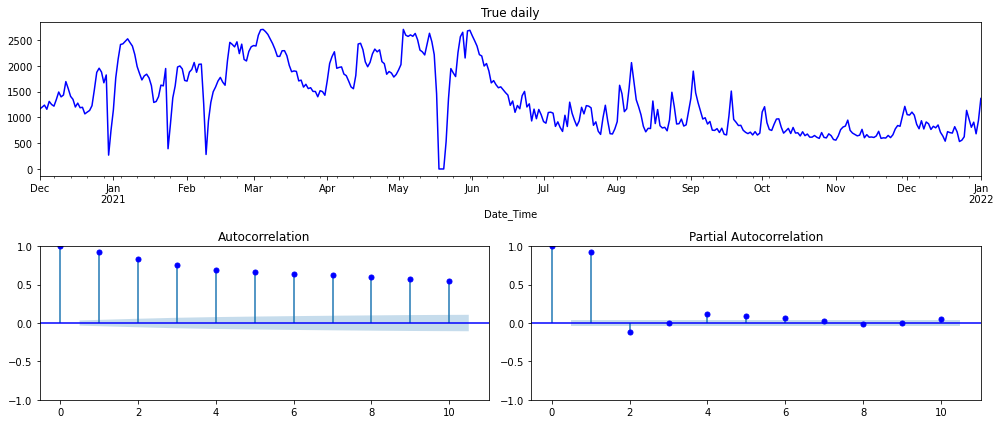

In [32]:
'''
True daily plot
'''
tsplot(data_daily.Value.dropna(), label = "True daily", filepath=plots_path / 'daily.png')

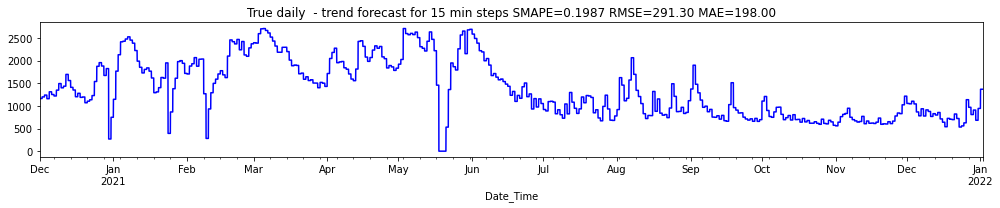

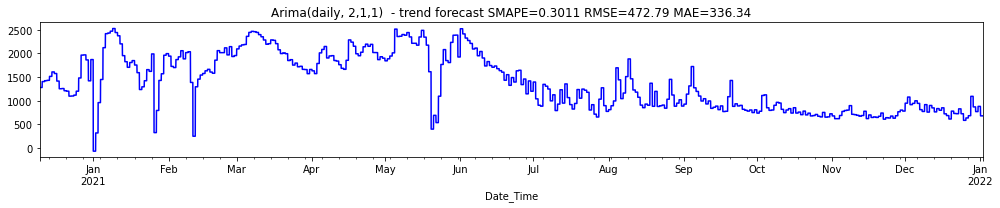

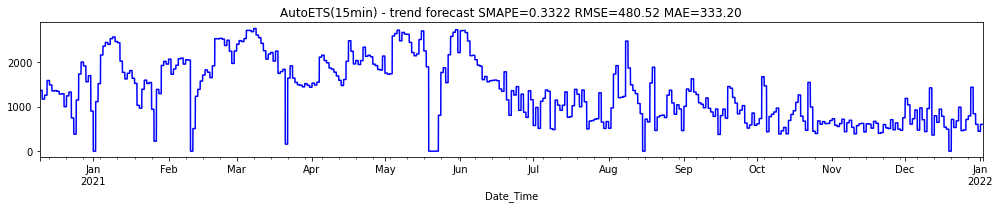

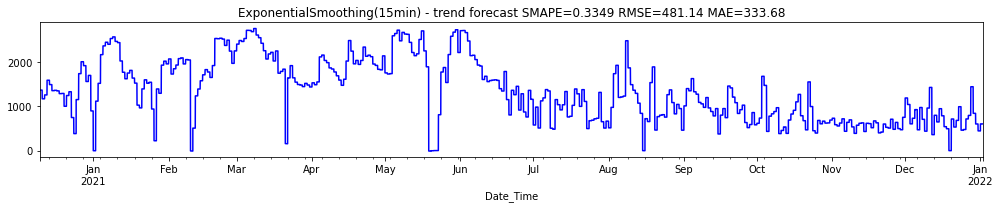

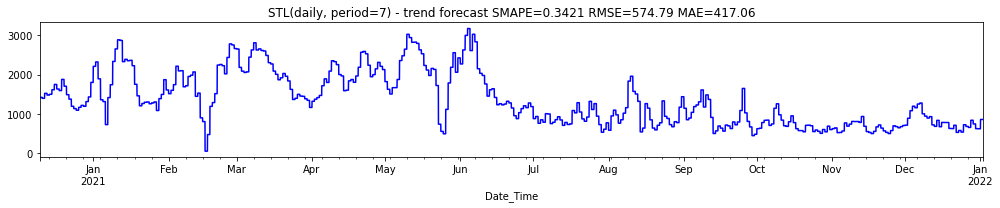

In [33]:
'''
Trend forecasts comparison
- daily forecasts are forward filled to 15 min steps.
'''
data['Value_daily'] = value_daily
data['Value_daily'] = data['Value_daily'].ffill()

trend_eval_plot(data['Value'], data['Value_daily'], label="True daily  - trend forecast for 15 min steps", filepath=plots_path / 'true_daily_detr.png')
del data['Value_daily'] #NOTE IMPORTANT


trend_eval_plot(data['Value'], data['arima_current'], label="Arima(daily, 2,1,1)  - trend forecast", filepath=plots_path / 'arima_detr.png')
trend_eval_plot(data['Value'], data['ets'], label="AutoETS(15min) - trend forecast", filepath=plots_path / 'ets_detr.png')
trend_eval_plot(data['Value'], data['exp'], label="ExponentialSmoothing(15min) - trend forecast", filepath=plots_path / 'exp_detr.png')
trend_eval_plot(data['Value'], data['stl'], label="STL(daily, period=7) - trend forecast", filepath=plots_path / 'stl_detr.png')

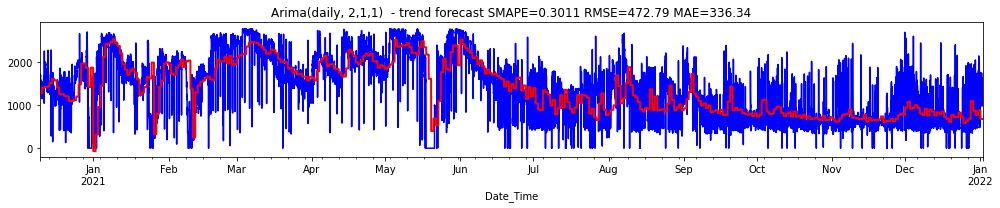

In [34]:
trend_eval_plot(data['Value'], data['arima_current'], label="Arima(daily, 2,1,1)  - trend forecast", compare=True,
                filepath=plots_path / 'arima_detr_comparison.png'
                )

In [35]:
data.to_csv(product['data'])